In [28]:
## TP2 ok
## TP 10 bad data
## TP3 goood (the best)


import numpy as np
from pandas import Series,DataFrame
import pandas as pd
import time
import datetime
import json
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import scipy.cluster.hierarchy as hcluster
from sklearn import mixture
import itertools
from scipy import linalg
from itertools import cycle



%matplotlib inline
mpl.rcParams['figure.figsize'] = (12.0, 8.0)



MINIMUM_COOKING_TIME = 60*10

cookingOutput = open('cookingOutputTP10.json')
outputDict = json.load(cookingOutput)

cookingOutputStat = open('cookingOutputTP10stat.json')
outputDictStat = json.load(cookingOutputStat)
        
## save to json file
cookdaysOutput = open('cookingOutputTP10cookdays.json')
cookdaysDict = json.load(cookdaysOutput)


## just to collect(firstHalf) cookingMeanTimes
## in format 16:10:34 : 2, 12:15:34 : 1
## is later going to be converted to series and resampled
learningMeanTimeCounterDict = defaultdict(int)
## second for other half of data
cookingMeanTimeCounterDict = defaultdict(int)


## collecting
# sorted by date
orderedDict = collections.OrderedDict(sorted(outputDict.items()))
keyLength = len(orderedDict.keys())
print "keyLength:", keyLength
## collect values from first half of data
for counter, key in enumerate(orderedDict.keys()):
    #if counter<keyLength/2:
    #print 1, counter,",", key
    if outputDict[key]["hclusters"] > 0 :
        clusters = outputDict[key]["clusters"]
        #print "clusternr:",clusters
        clusterint = 0
        while clusterint < clusters:
            clusteri = str(clusterint)
            clusterMean = outputDict[key][clusteri][1]
            clusterMeanTime = outputDict[key][clusteri][2]
            #print date, "cooking",outputDict[key][clusteri][0] , "start:",outputDict[key][clusteri][3],"end:",outputDict[key][clusteri][4],"mean:",outputDict[key][clusteri][1] ," deviation: ", (clusterMean-mean)/ (60*60*12), " %" 
                    
            if counter<keyLength/2:
                print  1, counter,",", key, clusterMeanTime
                ## append cookTimes to dict with counter
                learningMeanTimeCounterDict[clusterMeanTime] += 1
            else:
                print  2, counter,",", key, clusterMeanTime
                ## append cookTimes to second portion 
                cookingMeanTimeCounterDict[clusterMeanTime] += 1
            clusterint +=1
            


keyLength: 71
1 1 , 2010_05_12 07:36:25
1 3 , 2010_05_14 10:33:03
1 4 , 2010_05_15 12:36:27
1 4 , 2010_05_15 08:55:49
1 4 , 2010_05_15 10:05:13
1 6 , 2010_05_17 06:08:42
1 9 , 2010_05_20 05:55:33
1 12 , 2010_05_23 12:33:33
1 12 , 2010_05_23 10:16:19
1 15 , 2010_05_26 06:22:49
1 18 , 2010_05_29 06:13:33
1 19 , 2010_05_30 10:16:15
1 19 , 2010_05_30 10:45:17
1 19 , 2010_05_30 09:42:28
1 19 , 2010_05_30 09:13:32
1 20 , 2010_05_31 05:54:14
1 22 , 2010_06_07 14:44:41
1 23 , 2010_06_08 11:50:19
1 24 , 2010_06_09 09:52:19
1 25 , 2010_06_10 12:53:05
1 34 , 2010_06_19 09:32:14
2 39 , 2010_06_24 13:43:56
2 40 , 2010_06_25 10:08:53
2 48 , 2010_07_08 06:49:17
2 49 , 2010_08_03 13:16:20
2 50 , 2010_08_04 17:30:16
2 52 , 2010_08_06 17:00:09
2 58 , 2010_08_12 09:04:00
2 60 , 2010_08_14 12:20:03
2 62 , 2010_08_16 17:40:14
2 62 , 2010_08_16 11:14:36
2 62 , 2010_08_16 10:24:53
2 65 , 2010_08_19 18:00:18
2 65 , 2010_08_19 13:47:12
2 66 , 2010_08_20 12:24:00


In [29]:
len(outputDict.keys())

71

In [30]:
## print cook statistics
mean = outputDictStat['mean']
stddev = outputDictStat['stddev']
print "mean: ", time.strftime('%H:%M:%S', time.gmtime(mean))
print "stddev: ", time.strftime('%H:%M:%S', time.gmtime(stddev))

# number of days cook vs no cook
yes = cookdaysDict['yes']
no = cookdaysDict['no']

print "daysCooked:", yes
print "noCooking:", no
print "totalDays:", yes+no
print "percentageCooked:", yes*100/(yes+no)
print "percentageNoCook:", no*100/(yes+no)

mean:  11:00:45
stddev:  03:19:34
daysCooked: 26
noCooking: 45
totalDays: 71
percentageCooked: 36
percentageNoCook: 63


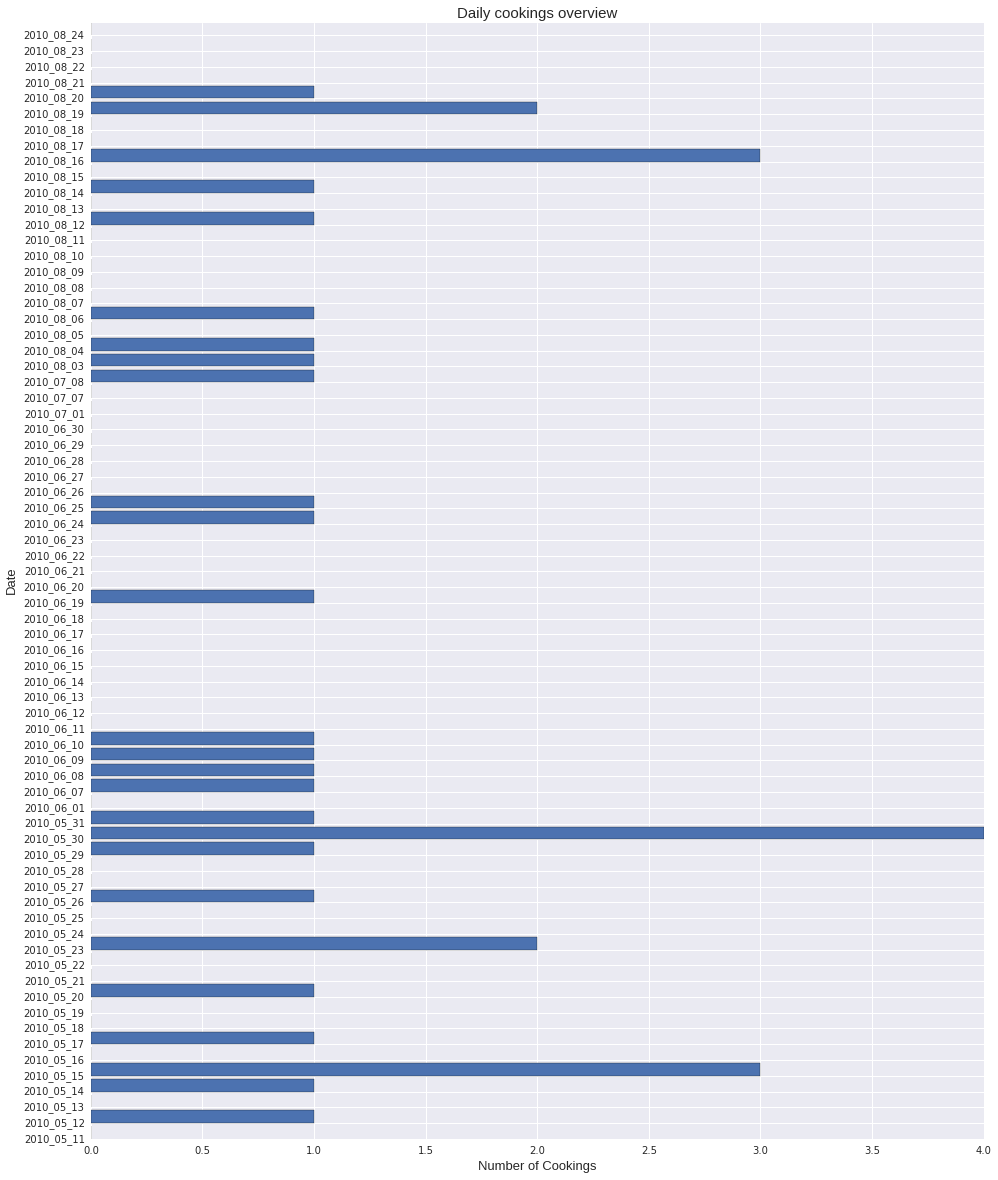

In [32]:
## plot cooking distribution over days
import seaborn as sns
cookingCounts = [value['hclusters'] for value in orderedDict.values()]

#X = np.arange(len(outputDict))
#print X

plt.figure()
mpl.rcParams['figure.figsize'] = (16.0, 20.0)
#fig = plt.figure()
#ax = fig.add_subplot(111)

X = np.arange(len(orderedDict))

plt.barh(X, cookingCounts)
#plt.xticks(X+0.5, outputDict.keys(), rotation='vertical')
plt.yticks(X, orderedDict.keys())
#ymax = max(cookingCounts) + 1
#ax.ylim(0, ymax)
plt.xlabel('Number of Cookings' , fontsize=13)
plt.ylabel('Date', fontsize=13)
plt.title('Daily cookings overview', fontsize=15)
plt.autoscale(tight=True)
plt.show()


sumEvents: 21


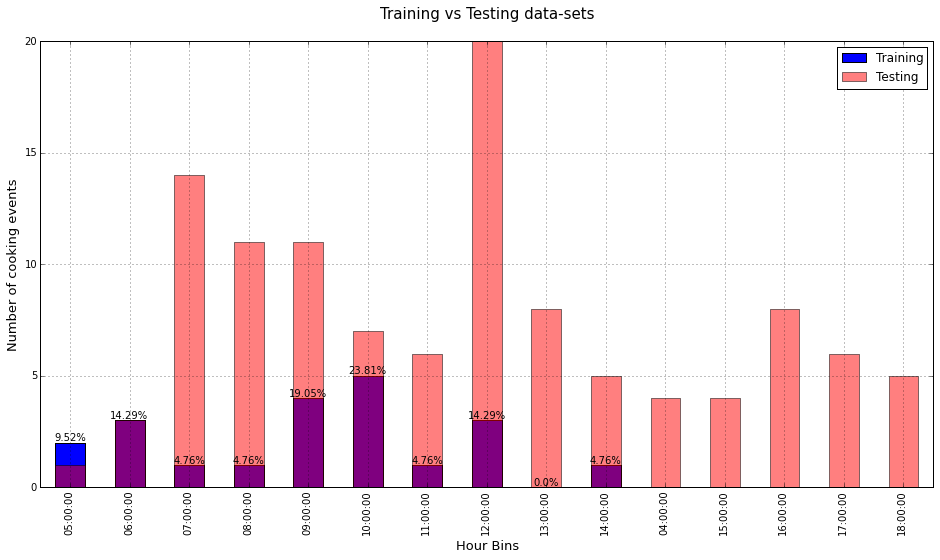

In [48]:
#mpl.rcParams['figure.figsize'] = (12.0, 6.0)
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
from pandas.tools.plotting import andrews_curves
## first portion of data ##
## convert to series ##
learningMeanTimeSeries = Series()
#datetime.datetime.strptime(key, '%H:%M:%S').time()

## we have to add a DATE to a key of MeanTimes to be able to resample 
date = '20-05-2010'
for key in learningMeanTimeCounterDict:
    keyDateString = date + ' ' + key
    #print keyDateString
    keyDate = datetime.strptime(keyDateString, '%d-%m-%Y %H:%M:%S')
    learningMeanTimeSeries = learningMeanTimeSeries.set_value(keyDate, learningMeanTimeCounterDict[key]) 

#learningMeanTimeSeries

learningMeanTimeSeries.index = pd.DatetimeIndex(learningMeanTimeSeries.index)
type(learningMeanTimeSeries.index)

# cookingMeanTimeGrouped1
# learnmeantimegroup60
sumEvents = learningMeanTimeSeries.sum()
print "sumEvents:", sumEvents

mpl.rcParams['figure.figsize'] = (16.0, 8.0)
lmtg60 = learningMeanTimeSeries.groupby(pd.TimeGrouper('60Min')).sum()
lmtg60 = lmtg60.fillna(0)
ax = plt.figure()

# plot bars
ax = lmtg60.plot(kind='bar', color='b', label="Training")
ax = cmtg60.plot(kind='bar', color='r', alpha=.5, label="Testing",ax=ax)

# plot probabilities
#ax = lmtg60Df.plot(x=lmtg60Df.index, y='eventprobability', color='b',label="Training data probability")
#ax = cmtg60Df.plot(x=cmtg60Df.index, y='eventprobability', color='r',ax=ax, label="Testing data probability")
ax.grid(True)

# Now make some labels
labels = list()
times = list()
for idx in lmtg60.iteritems():
    labels.append(str(round(idx[1]*100/sumEvents,2))+"%")
    times.append(idx[0].time())
    
for idx2 in cmtg60.iteritems():
    time2 = idx2[0].time()
    if time2 not in times:
        times.append(time2)
    


plt.xlabel('Hour Bins', fontsize=13)
plt.ylabel('Number of cooking events', fontsize=13)
plt.title('Training vs Testing data-sets\n', fontsize=15)
plt.legend(loc='upper right');

rects = ax.patches    
ax.set_xticklabels(times)

# append labels to plot
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
#ax.set_xticklabels(lmtg60)


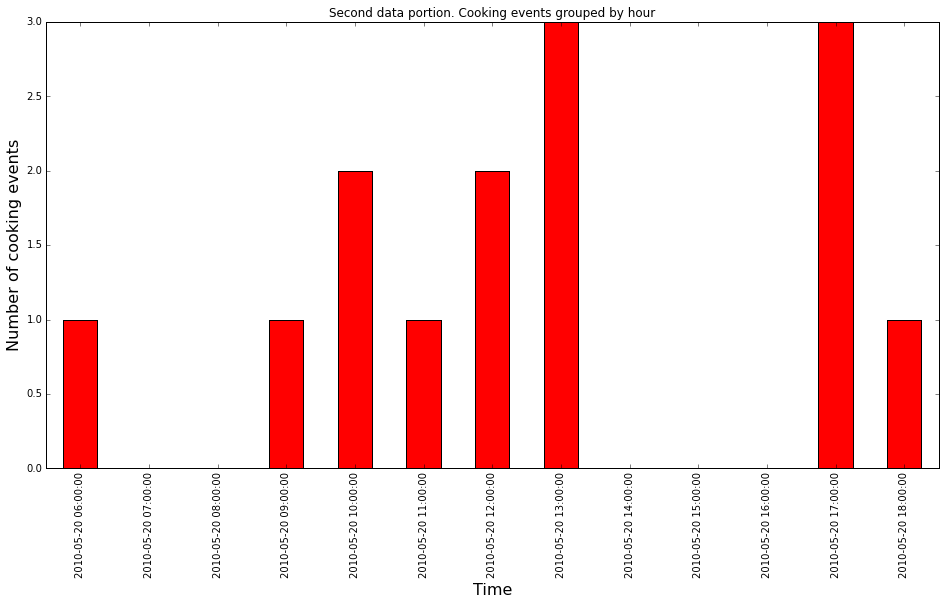

In [49]:
## second portion of data ##
## convert to series ##
cookingMeanTimeSeries = Series()

## we have to add a DATE to a key of MeanTimes to be able to resample 
date = '20-05-2010'
for key in cookingMeanTimeCounterDict:
    keyDateString = date + ' ' + key
    #print keyDateString
    keyDate = datetime.strptime(keyDateString, '%d-%m-%Y %H:%M:%S')
    cookingMeanTimeSeries = cookingMeanTimeSeries.set_value(keyDate, cookingMeanTimeCounterDict[key]) 

#cookingMeanTimeSeries
cookingMeanTimeSeries.index = pd.DatetimeIndex(cookingMeanTimeSeries.index)
#type(cookingMeanTimeSeries2.index)


cmtg60 = cookingMeanTimeSeries.groupby(pd.TimeGrouper('60Min')).sum()
cmtg60 = cmtg60.fillna(0)
## PLOT TOGETHER ##
fig, ax = plt.subplots()
cmtg60.plot(kind='bar', color='r')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of cooking events', fontsize=16)
plt.title('Second data portion. Cooking events grouped by hour')
plt.show(fig)

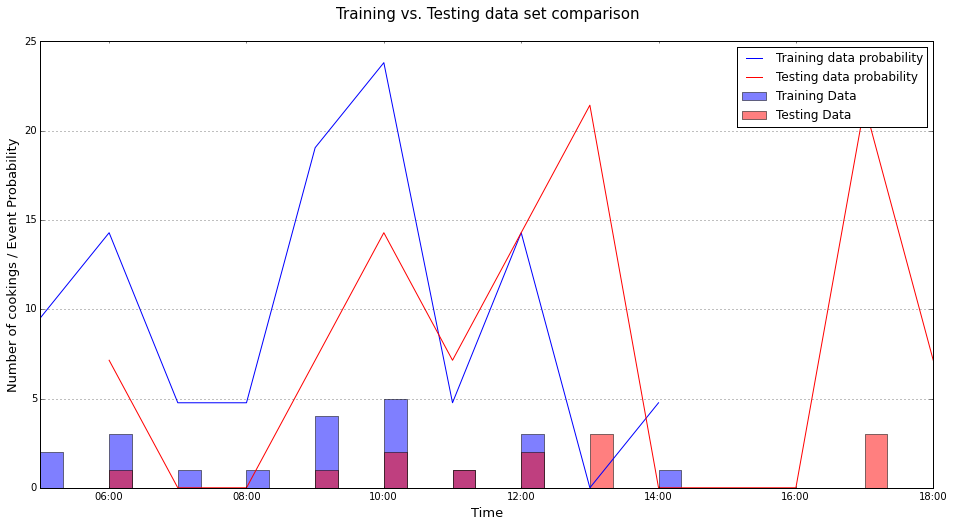

deviation: 7.59586419937


In [56]:
# calculate probabilities
lmtg60Df = pd.DataFrame(lmtg60, columns=['countevents'])
cmtg60Df = pd.DataFrame(cmtg60, columns=['countevents'])
lmtg60Df['eventprobability'] = lmtg60Df.countevents.map( lambda row: (row*100)/lmtg60Df['countevents'].sum() )
cmtg60Df['eventprobability'] = cmtg60Df.countevents.map( lambda row: (row*100)/cmtg60Df['countevents'].sum() )

lmtg60Df.index = pd.to_datetime(lmtg60Df.index)

fig = plt.figure()
#ax = fig.add_subplot(111)
ax = lmtg60Df.plot(x=lmtg60Df.index, y='eventprobability', color='b',label="Training data probability")
ax = cmtg60Df.plot(x=cmtg60Df.index, y='eventprobability', color='r',ax=ax, label="Testing data probability")
ax.bar(lmtg60.index, lmtg60.values, color='b',  alpha=.5,label="Training Data", width=20)
ax.bar(cmtg60.index, cmtg60.values, color='r', alpha=.5,label="Testing Data", width=20)
ax.grid(True)
#plt.axhline(y=lmtg60Df.eventprobability.std(), linewidth=1, color = 'k', label="Cooking Probability STD")

#plt.text(y=lmtg60Df.eventprobability.std(),'blah',rotation=90)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Number of cookings / Event Probability', fontsize=13)
plt.title('Training vs. Testing data set comparison\n', fontsize=15)
plt.legend(loc='upper right');
plt.show(fig)
print "deviation:", lmtg60Df.eventprobability.std()
#ci = group60LearedDf.aggregate(lambda x: np.std(x) / x.count() * 1.96)
#lmtg60Df.index.name="hour"
#lmtg60Df

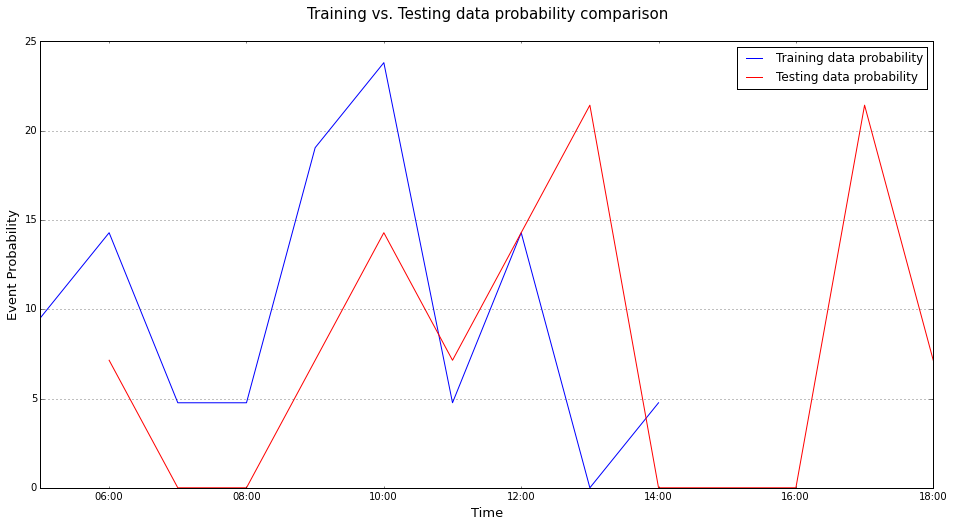

In [51]:
# calculate probabilities
lmtg60Df = pd.DataFrame(lmtg60, columns=['countevents'])
cmtg60Df = pd.DataFrame(cmtg60, columns=['countevents'])
lmtg60Df['eventprobability'] = lmtg60Df.countevents.map( lambda row: (row*100)/lmtg60Df['countevents'].sum() )
cmtg60Df['eventprobability'] = cmtg60Df.countevents.map( lambda row: (row*100)/cmtg60Df['countevents'].sum() )

lmtg60Df.index = pd.to_datetime(lmtg60Df.index)

fig = plt.figure()
#ax = fig.add_subplot(111)
ax = lmtg60Df.plot(x=lmtg60Df.index, y='eventprobability', color='b',label="Training data probability")
ax = cmtg60Df.plot(x=cmtg60Df.index, y='eventprobability', color='r',ax=ax, label="Testing data probability")
#ax.bar(lmtg60.index, lmtg60.values, color='b',  alpha=.5,label="Training Data", width=20)
#ax.bar(cmtg60.index, cmtg60.values, color='r', alpha=.5,label="Testing Data", width=20)
ax.grid(True)
#plt.axhline(y=lmtg60Df.eventprobability.std(), linewidth=1, color = 'k', label="Cooking Probability STD")

#plt.text(y=lmtg60Df.eventprobability.std(),'blah',rotation=90)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Event Probability', fontsize=13)
plt.title('Training vs. Testing data probability comparison\n', fontsize=15)
plt.show(fig)


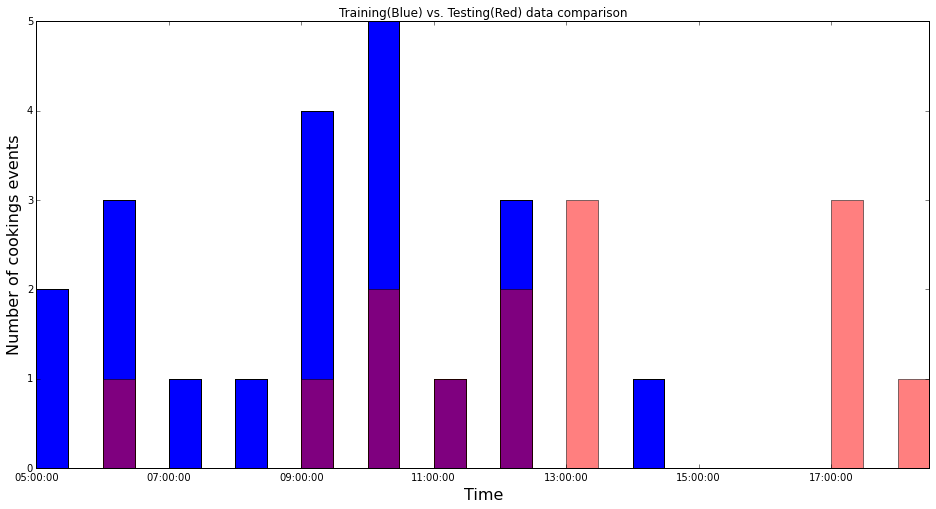

"\nfig, ax = plt.subplots(figsize=(18,6))\n#cmtg60.T.boxplot(ax=axes, grid=False, rot=90)\n\nax.plot(axes.get_xticks(),lmtg60)\n#ax.plot( cmtg60)\nplt.tight_layout()\nplt.xlabel('Survey')\nplt.ylabel('Population estimate')\n"

In [52]:
## PLOT TOGETHER ##

fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(lmtg60.index, lmtg60.values, color='b', label="Training Data", width=0.02)
ax.bar(cmtg60.index, cmtg60.values, color='r', alpha=.5, label="Testing Data", width=0.02)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of cookings events', fontsize=16)
plt.title('Training(Blue) vs. Testing(Red) data comparison')

plt.show(fig)


'''
fig, ax = plt.subplots(figsize=(18,6))
#cmtg60.T.boxplot(ax=axes, grid=False, rot=90)

ax.plot(axes.get_xticks(),lmtg60)
#ax.plot( cmtg60)
plt.tight_layout()
plt.xlabel('Survey')
plt.ylabel('Population estimate')
'''

In [53]:
## Calculate Hitrate by Hour ##
hourhitsCount = len(cmtg60[(cmtg60[cmtg60>0].index.isin(lmtg60[lmtg60>0].index))])
hourhitsCount
hhitrate = (100*hourhitsCount)/len(cmtg60[cmtg60>0].values)
print "hitrate by hour:",hhitrate, '%'

hitrate by hour: 62 %


In [54]:
print "hitrate by event number:", (100 * sum(cmtg60[(cmtg60[cmtg60>0].index.isin(lmtg60[lmtg60>0].index))].values))/sum(cmtg60.values)

hitrate by event number: 28.5714285714


In [55]:
## METHOD 2 ##

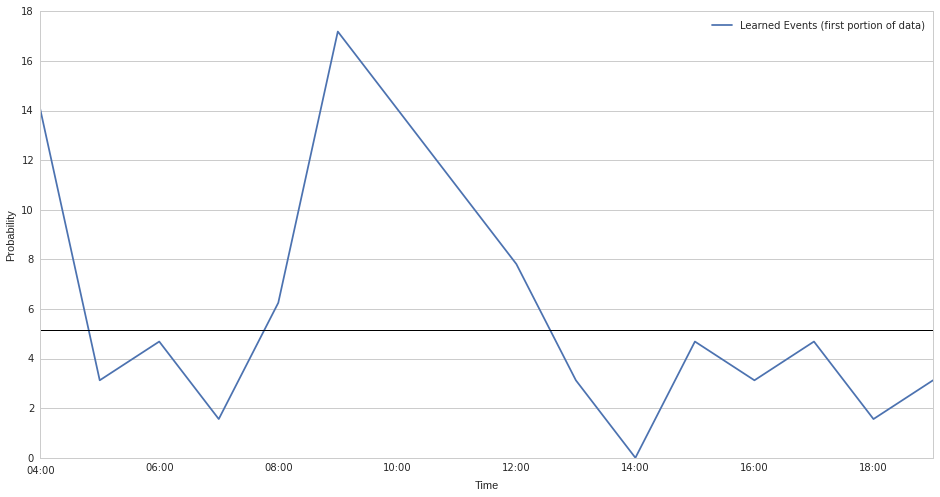

In [54]:
#fig, ax = plt.subplots()
lmtg60Df.plot(x=lmtg60Df.index, y='eventprobability', label="Learned Events (first portion of data)")
plt.axhline(y=lmtg60Df.eventprobability.std(), linewidth=1, color = 'k', label="Cooking Probability STD")
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show(fig)

In [55]:
lmtg60Df["stddiff"] = lmtg60Df.eventprobability - lmtg60Df.eventprobability.std()

lmtg60Df["tocluster"] = lmtg60Df.stddiff.map(lambda row: row > 0)
lmtg60Df["sec"] = lmtg60Df.index.map( lambda x: pd.to_datetime(x).hour*3600 + pd.to_datetime(x).minute*60 + pd.to_datetime(x).second )
cmtg60Df["sec"] = cmtg60Df.index.map( lambda x: pd.to_datetime(x).hour*3600 + pd.to_datetime(x).minute*60 + pd.to_datetime(x).second )
lmtg60Df

,countevents,eventprobability,stddiff,tocluster,sec
hour,,,,,
2010-05-20 04:00:00,9,14.0625,8.927601,True,14400
2010-05-20 05:00:00,2,3.1250,-2.009899,False,18000
2010-05-20 06:00:00,3,4.6875,-0.447399,False,21600
2010-05-20 07:00:00,1,1.5625,-3.572399,False,25200
2010-05-20 08:00:00,4,6.2500,1.115101,True,28800
2010-05-20 09:00:00,11,17.1875,12.052601,True,32400
2010-05-20 10:00:00,9,14.0625,8.927601,True,36000
2010-05-20 11:00:00,7,10.9375,5.802601,True,39600
2010-05-20 12:00:00,5,7.8125,2.677601,True,43200


In [56]:
# create DF from dict
## first one for learned data ##
learningMeanTimeCounterDict.keys()
learnedCookingTimesDF = pd.DataFrame(learningMeanTimeCounterDict.items(), columns=['CMeanTime', 'number'])
learnedCookingTimesDF['CMeanTime'] = pd.to_datetime(learnedCookingTimesDF['CMeanTime'])
learnedCookingTimesDF.head()

## second one for comparison data ##
#learningMeanTimeCounterDict.keys()
newCookingTimesDF = pd.DataFrame(cookingMeanTimeCounterDict.items(), columns=['CMeanTime', 'number'])
newCookingTimesDF['CMeanTime'] = pd.to_datetime(newCookingTimesDF['CMeanTime'])



## first half of data
learnedCookingTimesDF['sec'] = learnedCookingTimesDF.CMeanTime.map( lambda x: pd.to_datetime(x).hour*3600 + pd.to_datetime(x).minute*60 + pd.to_datetime(x).second )
## second half of data
newCookingTimesDF['sec'] = newCookingTimesDF.CMeanTime.map( lambda x: pd.to_datetime(x).hour*3600 + pd.to_datetime(x).minute*60 + pd.to_datetime(x).second )

newCookingTimesDF.head()

,CMeanTime,number,sec
0,2016-06-07 17:06:14,1,61574
1,2016-06-07 09:49:57,1,35397
2,2016-06-07 10:41:54,1,38514
3,2016-06-07 17:09:03,1,61743
4,2016-06-07 04:52:09,1,17529


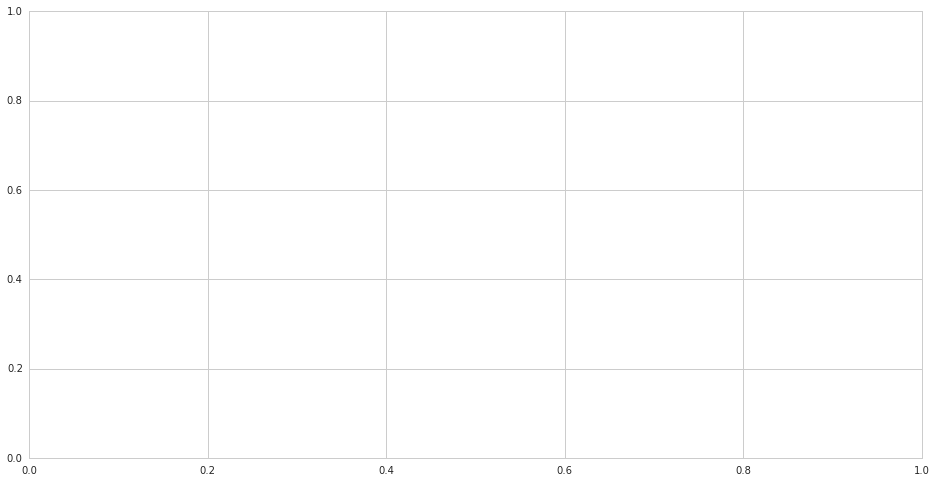

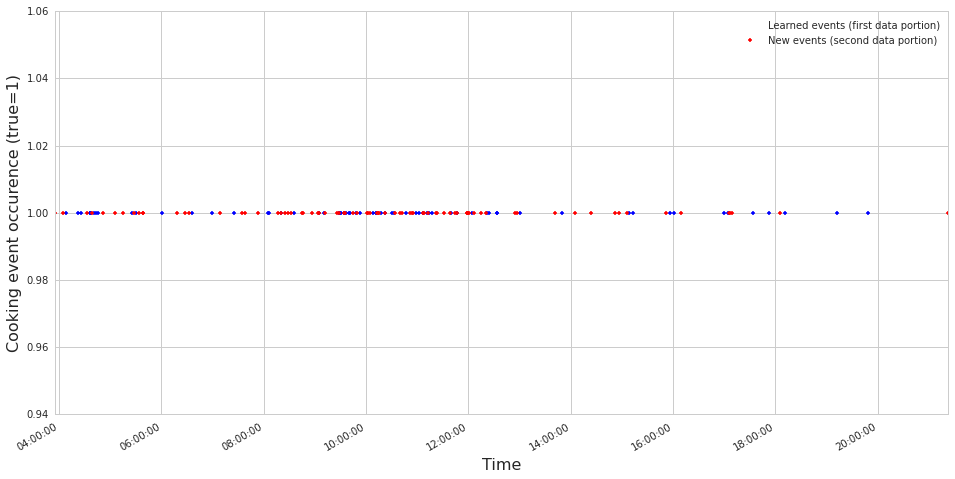

In [57]:
fig, ax = plt.subplots()
ax = learnedCookingTimesDF.plot(x=learnedCookingTimesDF.CMeanTime, y="number", style='.',color='b', label="Learned events (first data portion)")
newCookingTimesDF.plot(x=newCookingTimesDF.CMeanTime, y="number", style='.', label="New events (second data portion)", ax=ax, color='r')
plt.ylabel("Cooking event occurence (true=1)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.show(fig)

In [58]:
#### Synchronise two dataframes ####
## needed for second method ##
#group60LearedDf["stddiff"] = group60LearedDf.eventprobability - group60LearedDf.eventprobability.std()

#list(group60LearedDf.between_time('5:00','5:01').values)[0][3]
learnedCookingTimesDF["tocluster"] = learnedCookingTimesDF.CMeanTime.map( lambda x:  list(lmtg60Df.between_time(str(x.hour) +':00', str(x.hour) +':01').values)[0][3])
learnedCookingTimesDF[learnedCookingTimesDF["tocluster"]==True].head()

,CMeanTime,number,sec,tocluster
0,2016-06-07 08:06:48,1,29208,True
1,2016-06-07 08:35:36,1,30936,True
2,2016-06-07 09:36:17,1,34577,True
5,2016-06-07 09:40:19,1,34819,True
6,2016-06-07 11:02:04,1,39724,True


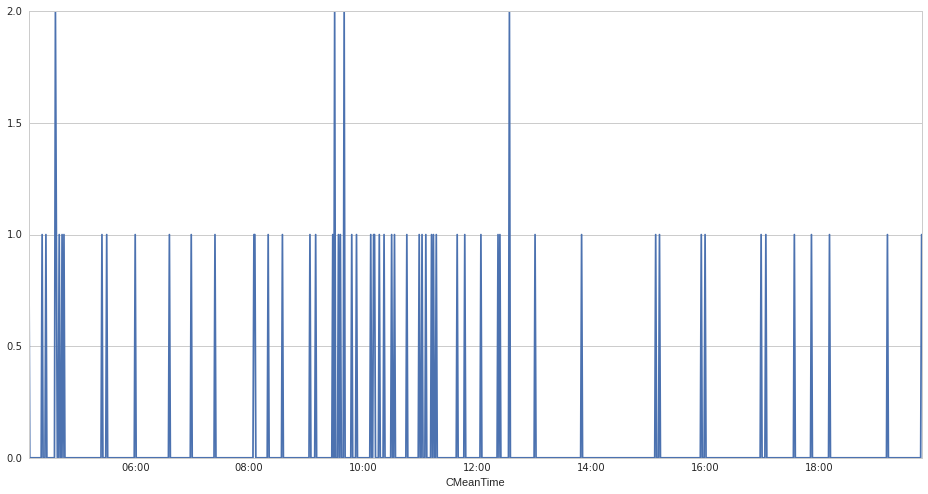

In [59]:
# create Series from df while plotting out of is not cool
#index_values = pd.date_range("00:00", "23:59", freq="1min").time
s = pd.Series(data=learnedCookingTimesDF.number.values, index=pd.to_datetime(learnedCookingTimesDF.CMeanTime))
#s = s.reindex(pd.date_range("00:00", "23:59", freq="1min").time, fill_value=0)
# regroup
s = s.groupby(pd.TimeGrouper('1Min')).sum()
s = s.fillna(0)
#s=s.reindex_like(index_values)
s.plot()

In [60]:
print "cookings to cluster:", len(learnedCookingTimesDF[(learnedCookingTimesDF.tocluster==True)].number.values)
print "all cookings:", len(learnedCookingTimesDF.number.values)

cookings to cluster: 45
all cookings: 64


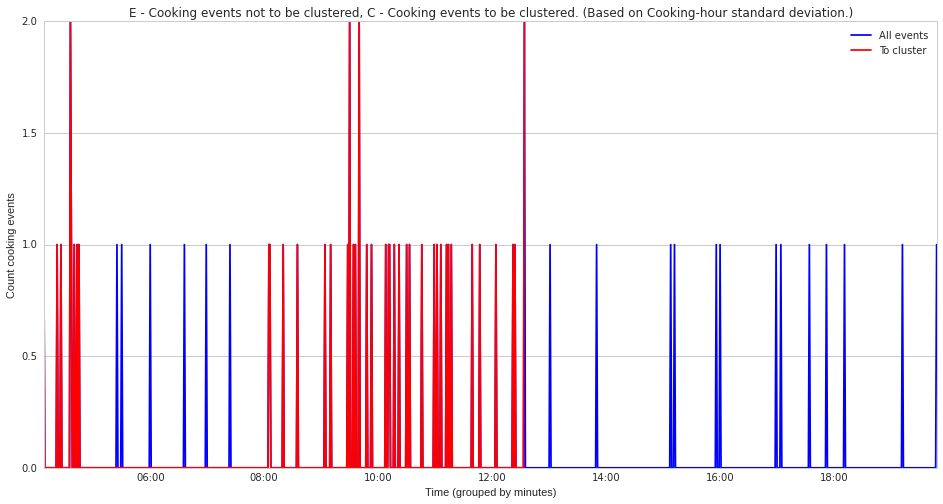

In [61]:
# create DF only out of tocluster==true items
learnedCookingTimesToCluster = pd.DataFrame(learnedCookingTimesDF[(learnedCookingTimesDF.tocluster==True)])
## to compare when values are filtered
# create Series from df
stocluster = pd.Series(data=learnedCookingTimesToCluster.number.values, index=pd.to_datetime(learnedCookingTimesToCluster.CMeanTime))

# regroup
stocluster = stocluster.groupby(pd.TimeGrouper('1Min')).sum()
stocluster = stocluster.fillna(0)
#s=s.reindex_like(index_values)
fig, ax = plt.subplots()
ax = s.plot(label="shit", color="b")
ax = stocluster.plot(label="bla", color="r")
plt.xlabel('Time (grouped by minutes)')
plt.ylabel('Count cooking events')
plt.legend(("All events","To cluster"))
plt.title("E - Cooking events not to be clustered, C - Cooking events to be clustered. (Based on Cooking-hour standard deviation.) ")
plt.show(fig)

In [62]:
# data from clustered DF
data = learnedCookingTimesToCluster[['sec','number']].values
# data from learned DF
data2 = learnedCookingTimesDF[['sec','number']].values
# add some value just to be visible

newCookingTimesDF['number'] = newCookingTimesDF['number']+1
newData2 = newCookingTimesDF[['sec','number']].values
newCookingTimesDF['number'] = newCookingTimesDF['number']-1

newCookingTimesDF['number'] = newCookingTimesDF['number']+5
newData = newCookingTimesDF[['sec','number']].values 

In [63]:
print "toclusterElements:", len(data)
print "trainingElements:", len(data2)

toclusterElements: 45
trainingElements: 64


(-5.0, 20.0)
(0.0, 90000.0)


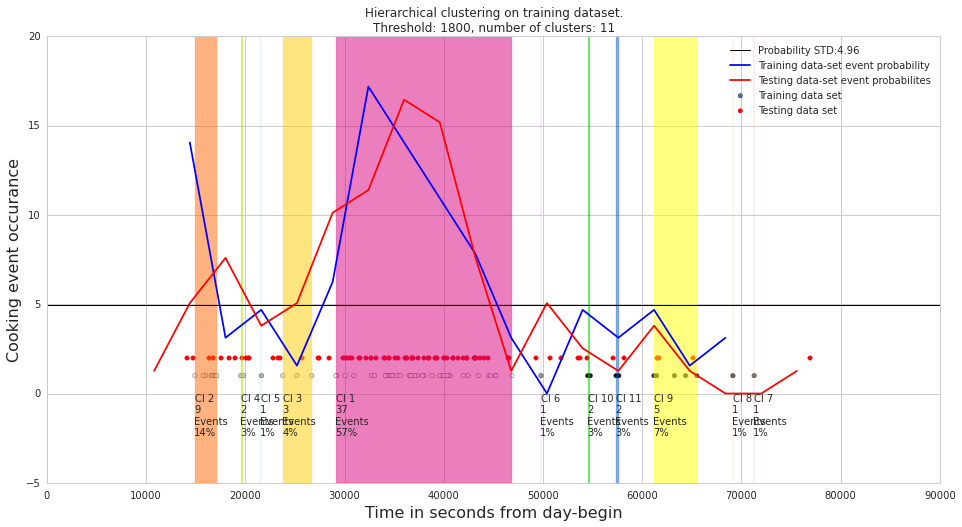

[ 1  1  1  9  4  1  1  1  2  1  1  1  4  1  1  1  1  1  1  1 10  1  1  6  1
  1  3  1  1  7  2  1 10  8  3  1  1  5  1  1  1  2  2  1  1  1  3  2  9  1
 11  1  9 11  1  2  9  1  2  1  9  1  2  2]


In [64]:
clr = ['#2200CC' ,'#D9007E' ,'#FF6600' ,'#FFCC00' ,'#ACE600' ,'#0099CC' ,
    '#8900CC' ,'#FF0000' ,'#FF9900' ,'#FFFF00' ,'#00CC01' ,'#0055CC']

## use both plots to compare (data(data to cluster) && data2(all data))
# clustering
thresh = 1800


ALLDATA = data2
DATAFRAME = learnedCookingTimesDF


#clusters = hcluster.fclusterdata(data, thresh, criterion="distance")
clusters = hcluster.fclusterdata(ALLDATA, thresh, criterion="distance")

for cluster in set(clusters):
    for point in ALLDATA[clusters==cluster, 0]:
        #print point , "c:", cluster
        learnedCookingTimesDF.loc[learnedCookingTimesDF.sec == point, 'hcluster1'] = cluster

        
# plotting
fig, ax = plt.subplots()
ax.scatter(*np.transpose(ALLDATA), c=clusters, label="Training data set")
for cluster in set(learnedCookingTimesDF.hcluster1.values):
    plt.axvspan(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].sec.min(),learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].sec.max(), color=clr[int(cluster)], alpha=0.5)  
    elementspercent = len(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster]) * 100 / len(learnedCookingTimesDF)
    #start = "Start:"+ str(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].CMeanTime.min().time())
    #end = "End:"+ str(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].CMeanTime.max().time())
    ax.annotate("Cl "+ str(int(cluster))+"\n"+str(len(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster]))+"\nEvents\n"+str(elementspercent)+"%\n", (learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].sec.min(),learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].number.max()-4.001))
#plt.axis("equal")
plt.axhline(y=cmtg60Df.eventprobability.std(), linewidth=1, color = 'k', label="Probability STD:"+str(round(cmtg60Df.eventprobability.std(),2)))
ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probability', color="b")
ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probabilites', color="r")
ax.scatter(*np.transpose(newData2), color='red',label='Testing data set', marker="o")
title = "Threshold: %i, number of clusters: %d" % (int(thresh), len(set(clusters)))
plt.title("Hierarchical clustering on training dataset.\n"+title)
plt.xlabel("Time in seconds from day-begin", fontsize=16)
plt.ylabel("Cooking event occurance", fontsize=16)
plt.legend(loc='upper right');
print plt.ylim()
print plt.xlim()
#plt.xlim(733907.27240740739,733907.65846064812)
plt.show()
print clusters

In [65]:
# add some value just to be visible
learnedCookingTimesDF['number'] = learnedCookingTimesDF['number']+3
data2 = learnedCookingTimesDF[['sec','number']].values

In [66]:
from datetime import datetime, date
elemarray = []
## append cluster# to datapoints
for cluster in set(clusters):
    
    print "cluster:", cluster
    startt = learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].CMeanTime.min().time()
    print "start:"+ str(startt)
    endt = learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].CMeanTime.max().time()
    print "end:" + str(endt) 
    print "duration:", datetime.combine(date.today(), endt) - datetime.combine(date.today(), startt)
    #print(endt - startt)
    print "elements:", len(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster])
    elemarray.append(len(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster]))
    print "elem percentage: ", len(learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster]) * 100 / len(learnedCookingTimesDF) 
    print "---"
    
print "elements:", len(elemarray)
np.std(elemarray)

cluster: 1
start:08:05:33
end:13:01:07
duration: 4:55:34
elements: 37
elem percentage:  57
---
cluster: 2
start:04:08:46
end:04:45:19
duration: 0:36:33
elements: 9
elem percentage:  14
---
cluster: 3
start:06:36:29
end:07:24:44
duration: 0:48:15
elements: 3
elem percentage:  4
---
cluster: 4
start:05:25:40
end:05:30:06
duration: 0:04:26
elements: 2
elem percentage:  3
---
cluster: 5
start:06:00:25
end:06:00:25
duration: 0:00:00
elements: 1
elem percentage:  1
---
cluster: 6
start:13:50:04
end:13:50:04
duration: 0:00:00
elements: 1
elem percentage:  1
---
cluster: 7
start:19:48:06
end:19:48:06
duration: 0:00:00
elements: 1
elem percentage:  1
---
cluster: 8
start:19:12:25
end:19:12:25
duration: 0:00:00
elements: 1
elem percentage:  1
---
cluster: 9
start:16:59:45
end:18:11:43
duration: 1:11:58
elements: 5
elem percentage:  7
---
cluster: 10
start:15:08:28
end:15:12:53
duration: 0:04:25
elements: 2
elem percentage:  3
---
cluster: 11
start:15:56:04
end:16:00:47
duration: 0:04:43
elements

10.124840576236984

In [67]:
clusterHitCouter = defaultdict(int)

def check_for_hit(row):
    eventTime = row["CMeanTime"].time()
    for cluster in set(clusters):
    #for dpgmmcluster, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
        #if len(CT[Y==dpgmmcluster,0]) > 0:
        clusterStartTime = learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].CMeanTime.min().time()
        #print "start:"+ str(startt)
        clusterEndTime = learnedCookingTimesDF[learnedCookingTimesDF.hcluster1==cluster].CMeanTime.max().time()

        if clusterStartTime <= eventTime <= clusterEndTime:
            print "hit", "s", clusterStartTime, "e", clusterEndTime, "event", eventTime
            clusterHitCouter[cluster] += 1
            return 1
        else:
            print "miss", "s", clusterStartTime, "e", clusterEndTime, "event", eventTime 
    
    return 0

newCookingTimesDF['hclusteringhit1'] = newCookingTimesDF.apply(lambda row: check_for_hit(row), axis=1)

miss s 08:05:33 e 13:01:07 event 17:06:14
miss s 04:08:46 e 04:45:19 event 17:06:14
miss s 06:36:29 e 07:24:44 event 17:06:14
miss s 05:25:40 e 05:30:06 event 17:06:14
miss s 06:00:25 e 06:00:25 event 17:06:14
miss s 13:50:04 e 13:50:04 event 17:06:14
miss s 19:48:06 e 19:48:06 event 17:06:14
miss s 19:12:25 e 19:12:25 event 17:06:14
hit s 16:59:45 e 18:11:43 event 17:06:14
hit s 08:05:33 e 13:01:07 event 09:49:57
hit s 08:05:33 e 13:01:07 event 10:41:54
miss s 08:05:33 e 13:01:07 event 17:09:03
miss s 04:08:46 e 04:45:19 event 17:09:03
miss s 06:36:29 e 07:24:44 event 17:09:03
miss s 05:25:40 e 05:30:06 event 17:09:03
miss s 06:00:25 e 06:00:25 event 17:09:03
miss s 13:50:04 e 13:50:04 event 17:09:03
miss s 19:48:06 e 19:48:06 event 17:09:03
miss s 19:12:25 e 19:12:25 event 17:09:03
hit s 16:59:45 e 18:11:43 event 17:09:03
miss s 08:05:33 e 13:01:07 event 04:52:09
miss s 04:08:46 e 04:45:19 event 04:52:09
miss s 06:36:29 e 07:24:44 event 04:52:09
miss s 05:25:40 e 05:30:06 event 04:52

In [68]:
## Hierarhical Clustering hit-miss comparison ##
method1HitEventsCounter = newCookingTimesDF[newCookingTimesDF.hclusteringhit1==1].sum()["hclusteringhit1"]
method1MissEventsCounter = len(newCookingTimesDF[newCookingTimesDF.hclusteringhit1==0]["hclusteringhit1"].values)

print "hits:", method1HitEventsCounter
print "miss:", method1MissEventsCounter
print "hitrate by event number:", (100*method1HitEventsCounter)/(method1HitEventsCounter+method1MissEventsCounter), "%" 

hits: 56
miss: 23
hitrate by event number: 70 %


In [69]:
# cluster hit statistics
for k in clusterHitCouter:
    print k, clusterHitCouter[k], clusterHitCouter[k]*100/(method1HitEventsCounter+method1MissEventsCounter)

9 4 5
2 2 2
3 1 1
4 1 1
1 48 60


(0.99399999999999999, 1.006)
(10000.0, 50000.0)


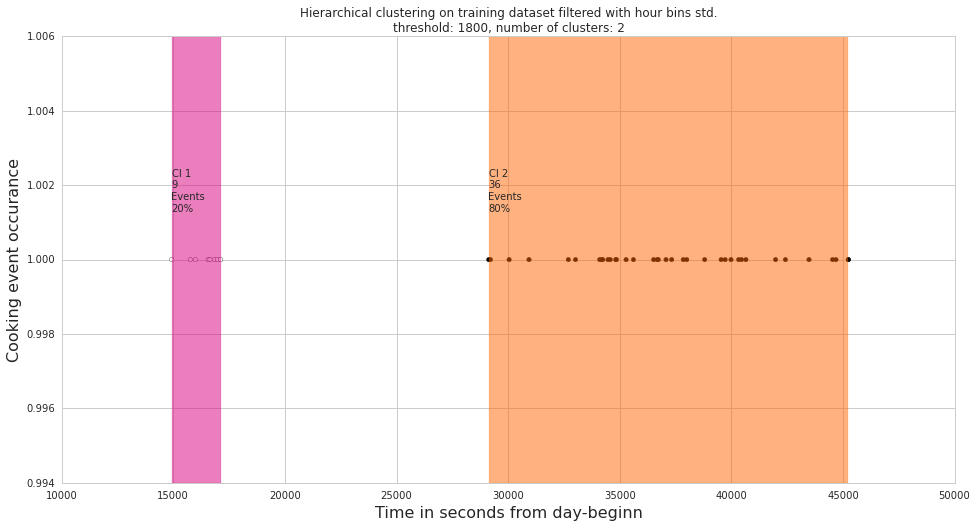

In [70]:
## use both plots to compare (data && data2)
# clustering
# change sensitivity
thresh = 1800

DATATOCLUSTER = data

#clusters = hcluster.fclusterdata(data, thresh, criterion="distance")
clusters = hcluster.fclusterdata(DATATOCLUSTER, thresh, criterion="distance")
for cluster in set(clusters):
    for point in data[clusters==cluster, 0]:
        #print point , "c:", cluster
        learnedCookingTimesToCluster.loc[learnedCookingTimesToCluster.sec == point, 'hcluster'] = cluster

fig, ax = plt.subplots()
# plotting
ax.scatter(*np.transpose(DATATOCLUSTER), c=clusters, label="Clustered data")
for cluster in set(learnedCookingTimesToCluster.hcluster.values):
    plt.axvspan(learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].sec.min(),learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].sec.max(), color=clr[int(cluster)], alpha=0.5)  
    elementspercent = len(learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster]) * 100 / len(learnedCookingTimesToCluster)
    #print elementspercent
    ax.annotate("Cl "+ str(int(cluster))+"\n"+str(len(learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster]))+"\nEvents\n"+str(elementspercent)+"%\n", (learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].sec.min(),learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].number.max()+0.001))
#plt.axis("equal")
title = "threshold: %i, number of clusters: %d" % (thresh, len(set(clusters)))
plt.title("Hierarchical clustering on training dataset filtered with hour bins std.\n"+title)
plt.xlabel("Time in seconds from day-beginn", fontsize=16)
plt.ylabel("Cooking event occurance", fontsize=16)
print plt.ylim()
print plt.xlim()
#plt.ylim(0.998,1.004)
plt.show()
#print clusters

In [71]:
## append cluster# to datapoints
for cluster in set(clusters):
    
    print "cluster:", cluster
    startt = learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].CMeanTime.min().time()
    print "start:"+ str(startt)
    endt = learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].CMeanTime.max().time()
    print "end:" + str(endt) 
    print "duration:", datetime.combine(date.today(), endt) - datetime.combine(date.today(), startt)
    #print(endt - startt)
    print "elements:", len(learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster])
    print "----"

cluster: 1
start:04:08:46
end:04:45:19
duration: 0:36:33
elements: 9
----
cluster: 2
start:08:05:33
end:12:34:05
duration: 4:28:32
elements: 36
----


In [72]:
#for index, row in newCookingTimesDF.iterrows():
#     print row['CMeanTime'], row['number']

#for cluster in set(clusters):
#    print cluster


from datetime import datetime, date

def check_for_hit(row):
    eventTime = row["CMeanTime"].time()
    for cluster in set(clusters):
        clusterStartTime = learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].CMeanTime.min().time()
        clusterEndTime = learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].CMeanTime.max().time()
        #print "cluster:", cluster, ",start:", clusterStartTime
        if clusterStartTime <= eventTime <= clusterEndTime:
            print "hit", "s", clusterStartTime, "e", clusterEndTime, "e", eventTime
            return 1
        else:
            print "miss", "s", clusterStartTime, "e", clusterEndTime, "e", eventTime 
            if eventTime < clusterStartTime:
                timediff = datetime.combine(date.today(), clusterStartTime) - datetime.combine(date.today(), eventTime)
                print "front:", timediff
            if eventTime > clusterEndTime:
                timediff = datetime.combine(date.today(), eventTime) - datetime.combine(date.today(), clusterStartTime)
                print "end:", timediff
    
    return 0

newCookingTimesDF['hit'] = newCookingTimesDF.apply(lambda row: check_for_hit(row), axis=1)

miss s 04:08:46 e 04:45:19 e 17:06:14
end: 12:57:28
miss s 08:05:33 e 12:34:05 e 17:06:14
end: 9:00:41
miss s 04:08:46 e 04:45:19 e 09:49:57
end: 5:41:11
hit s 08:05:33 e 12:34:05 e 09:49:57
miss s 04:08:46 e 04:45:19 e 10:41:54
end: 6:33:08
hit s 08:05:33 e 12:34:05 e 10:41:54
miss s 04:08:46 e 04:45:19 e 17:09:03
end: 13:00:17
miss s 08:05:33 e 12:34:05 e 17:09:03
end: 9:03:30
miss s 04:08:46 e 04:45:19 e 04:52:09
end: 0:43:23
miss s 08:05:33 e 12:34:05 e 04:52:09
front: 3:13:24
miss s 04:08:46 e 04:45:19 e 09:04:39
end: 4:55:53
hit s 08:05:33 e 12:34:05 e 09:04:39
miss s 04:08:46 e 04:45:19 e 11:44:15
end: 7:35:29
hit s 08:05:33 e 12:34:05 e 11:44:15
miss s 04:08:46 e 04:45:19 e 11:06:49
end: 6:58:03
hit s 08:05:33 e 12:34:05 e 11:06:49
miss s 04:08:46 e 04:45:19 e 06:27:21
end: 2:18:35
miss s 08:05:33 e 12:34:05 e 06:27:21
front: 1:38:12
miss s 04:08:46 e 04:45:19 e 10:22:44
end: 6:13:58
hit s 08:05:33 e 12:34:05 e 10:22:44
miss s 04:08:46 e 04:45:19 e 10:34:13
end: 6:25:27
hit s 0

In [73]:
## method 2 Hit/Miss Rate ##
method2HitEventsCounter = newCookingTimesDF[newCookingTimesDF.hit==1].sum()["hit"]
method2MissEventsCounter = len(newCookingTimesDF[newCookingTimesDF.hit==0]["hit"].values)

print "hits:", method2HitEventsCounter
print "miss:", method2MissEventsCounter
print "hitrate by event number:", (100*method2HitEventsCounter)/(method2HitEventsCounter+method2MissEventsCounter), "%" 

hits: 48
miss: 31
hitrate by event number: 60 %


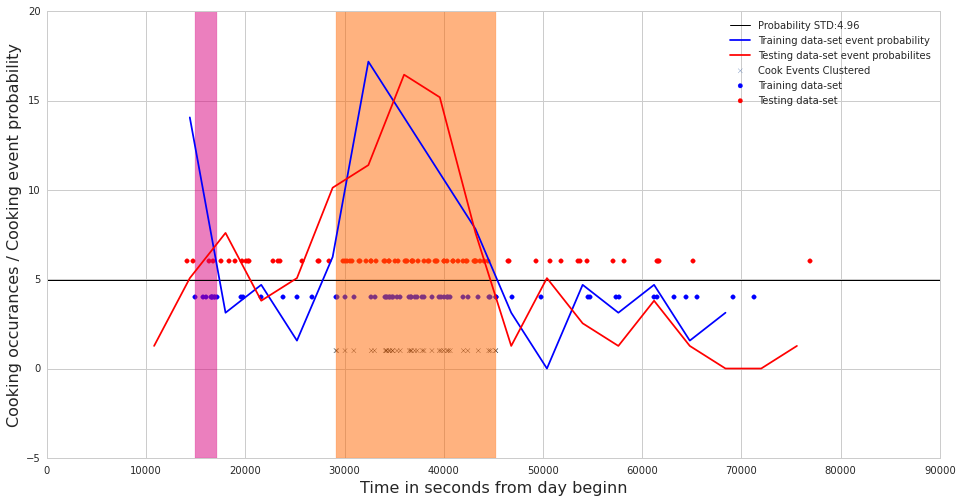

In [74]:
########### plot some shit ##############
clr = ['#2200CC' ,'#D9007E' ,'#FF6600' ,'#FFCC00' ,'#ACE600' ,'#0099CC' ,
    '#8900CC' ,'#FF0000' ,'#FF9900' ,'#FFFF00' ,'#00CC01' ,'#0055CC']
#fig = plt.figure()
fig, ax = plt.subplots()

ax.scatter(*np.transpose(data), c=clusters, label='Cook Events Clustered', marker="x")
text = 'ddd'#str(dframes4.datetime.min().date()) + "\n"
for cluster in set(learnedCookingTimesToCluster.hcluster.values):
    plt.axvspan(learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].sec.min(),learnedCookingTimesToCluster[learnedCookingTimesToCluster.hcluster==cluster].sec.max(), color=clr[int(cluster)], alpha=0.5)  

plt.axhline(y=cmtg60Df.eventprobability.std(), linewidth=1, color = 'k', label="Probability STD:"+str(round(cmtg60Df.eventprobability.std(),2)))
ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probability', color="b")
ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probabilites', color="r")
ax.scatter(*np.transpose(data2), color='blue',label='Training data-set', marker="o")
ax.scatter(*np.transpose(newData), color='red',label='Testing data-set', marker="o")
plt.xlabel('Time in seconds from day beginn', fontsize=16)
plt.ylabel('Cooking occurances / Cooking event probability', fontsize=16)
plt.legend(loc='upper right');
#plt.set_title("BLAA")
#plt.axvline(50)
plt.show(fig)

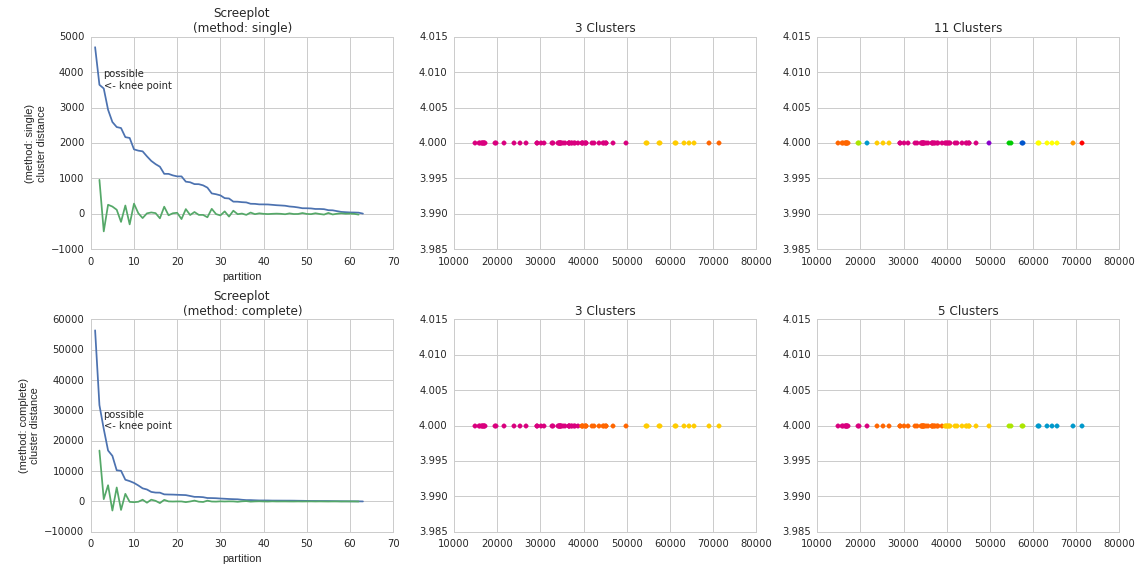

In [75]:
#a = learnedCookingTimesToCluster[['sec','number']].values
a = learnedCookingTimesDF[['sec','number']].values
fig, axes23 = plt.subplots(2, 3)

for method, axes in zip(['single', 'complete'], axes23):
    z = hcluster.linkage(a, method=method)

    # Plotting
    axes[0].plot(range(1, len(z)+1), z[::-1, 2])
    knee = np.diff(z[::-1, 2], 2)
    axes[0].plot(range(2, len(z)), knee)

    num_clust1 = knee.argmax() + 3
    knee[knee.argmax()] = 0
    num_clust2 = knee.argmax() + 3

    axes[0].text(num_clust1, z[::-1, 2][num_clust1-1], 'possible\n<- knee point')

    part1 = hcluster.fcluster(z, num_clust1, 'maxclust')
    part2 = hcluster.fcluster(z, num_clust2, 'maxclust')

    clr = ['#2200CC' ,'#D9007E' ,'#FF6600' ,'#FFCC00' ,'#ACE600' ,'#0099CC' ,
    '#8900CC' ,'#FF0000' ,'#FF9900' ,'#FFFF00' ,'#00CC01' ,'#0055CC']

    for part, ax in zip([part1, part2], axes[1:]):
        for cluster in set(part):
            ax.scatter(a[part == cluster, 0], a[part == cluster, 1], 
                       color=clr[cluster])

    m = '\n(method: {})'.format(method)
    plt.setp(axes[0], title='Screeplot{}'.format(m), xlabel='partition',
             ylabel='{}\ncluster distance'.format(m))
    plt.setp(axes[1], title='{} Clusters'.format(num_clust1))
    plt.setp(axes[2], title='{} Clusters'.format(num_clust2))

#plt.title("Possible tresholds and clustering possibilities")
plt.tight_layout()
plt.show()

In [76]:
len(set(clusters))

2

46867 71286
19540 26684
14926 17119
29133 45245


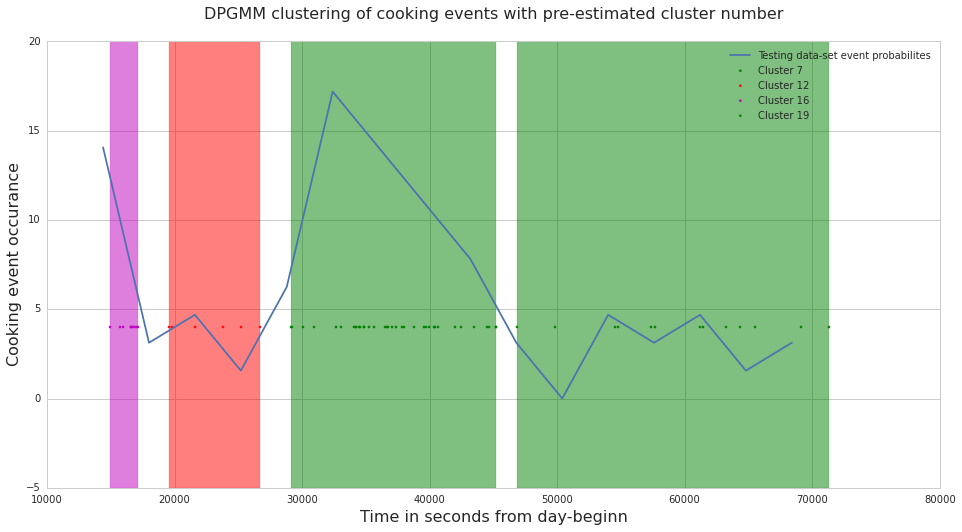

In [77]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
## describe with data && data2
## data -> clusters+2
## data2 -> clusters+3
## play with alpha
CT = data2
#dpgmm = mixture.DPGMM(n_components=len(set(clusters))+2, covariance_type='tied', params='wc', alpha=1,n_iter=1000)
dpgmm = mixture.DPGMM(n_components=20, covariance_type='tied', params='m', alpha=1,n_iter=100)
dpgmm.fit(CT)

fig, ax = plt.subplots()
for i, (clf, title) in enumerate([(dpgmm, 'DPGMM clustering of cooking events with pre-estimated cluster number\n')]):
    #splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(CT)
    for i, (mean, covar, color) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
        
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color, label = "Cluster " + str(i))
        print min(CT[Y_ == i, 0]), max(CT[Y_ == i, 0])
        plt.axvspan(min(CT[Y_ == i, 0]),max(CT[Y_ == i, 0]), color=color, alpha=0.5)  
        
        
        

        

    #ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probability')
    ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probabilites')
    #ax.scatter(*np.transpose(newData), color='red',label='Testing data-set', marker=".")
        
    plt.title(title, fontsize=16)
    plt.xlabel("Time in seconds from day-beginn", fontsize=16)
    plt.ylabel("Cooking event occurance", fontsize=16)
plt.legend(loc='upper right');

14926 17119
19540 26684
46867 71286
29133 45245


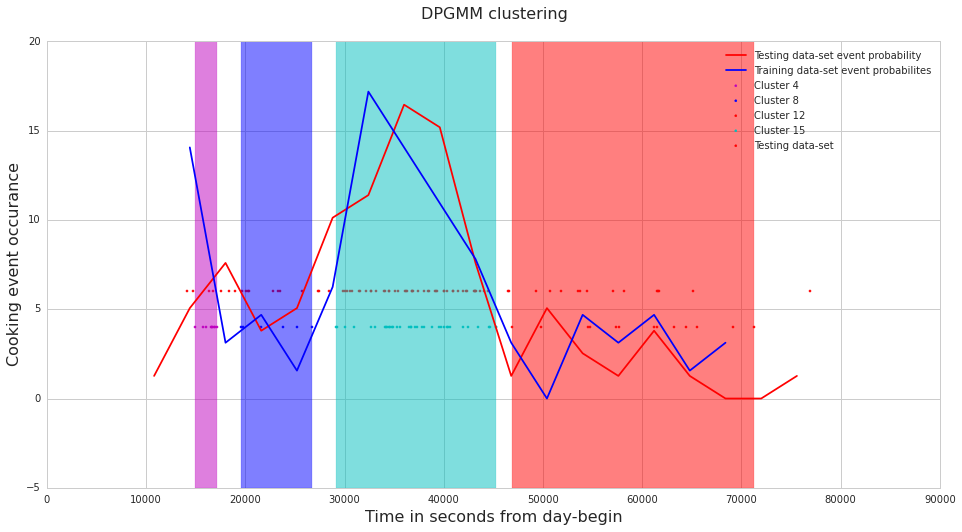

In [78]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
## describe with data && data2
## data -> clusters+2
## data2 -> clusters+3
## play with alpha
CT = data2
#print CT[:,0]
#dpgmm = mixture.DPGMM(n_components=len(set(clusters))+2, covariance_type='tied', params='wc', alpha=1,n_iter=1000)
dpgmm = mixture.DPGMM(n_components=20, covariance_type='full', params='wm', alpha=0.1,n_iter=1000)
dpgmm.fit(CT)

fig, ax = plt.subplots()
for i, (clf, title) in enumerate([(dpgmm, 'DPGMM clustering \n')]): 
    #splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(CT)
    for i, (mean, covar, color) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
        
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color, label = "Cluster " + str(i))
        print min(CT[Y_ == i, 0]), max(CT[Y_ == i, 0])
        plt.axvspan(min(CT[Y_ == i, 0]),max(CT[Y_ == i, 0]), color=color, alpha=0.5)  
        
        
        

        
    #a = sns.distplot(CT[:,0], kde=True, rug=False, hist=False,ax=ax, color='b',label="Training data set", norm_hist=False);
    ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probability', color='r')
    ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probabilites', color='b')
    ax.scatter(*np.transpose(newData), color='red',label='Testing data-set', marker=".")
        
    plt.title(title, fontsize=16)
    plt.xlabel("Time in seconds from day-begin", fontsize=16)
    plt.ylabel("Cooking event occurance", fontsize=16)
plt.legend(loc='upper right');

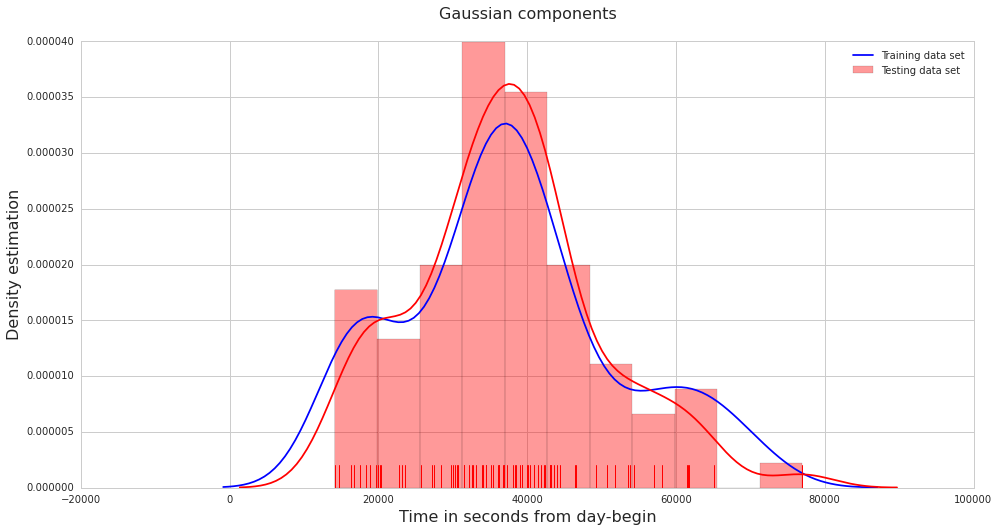

In [79]:
import seaborn as sns
plt.rcParams['figure.figsize']=(16,8)

#CT = learnedCookingTimesDF.sec.values
CT2 = newCookingTimesDF.sec.values
f, ax = plt.subplots()
import numpy as np
data = CT#[1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
sns.set_style('whitegrid')
sns.plt.title('Gaussian components \n', fontsize=16)
a = sns.distplot(CT[:,0], kde=True, rug=False, hist=False,ax=ax, color='b',label="Training data set", norm_hist=False);
#ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probability', color='r')
sns.distplot(CT2, kde=True, rug=True, ax=ax, color='r',label="Testing data set",norm_hist=True);
plt.legend()
sns.axlabel("Time in seconds from day-begin", "Density estimation", fontsize=16)




ValueError: zero-size array to reduction operation minimum which has no identity

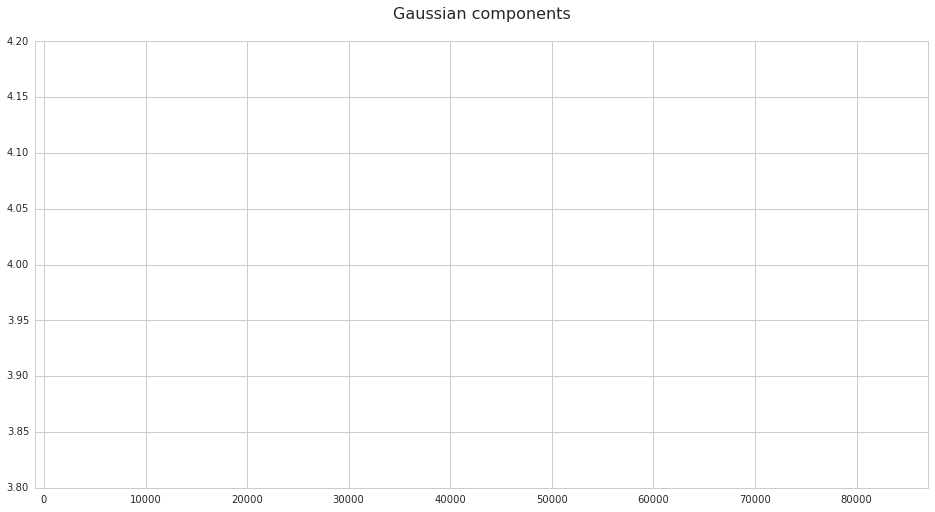

In [80]:
f, ax = plt.subplots()
#sns.distplot(CT, bins=20, kde=False, rug=True, ax=ax, color='b');
#sns.distplot(CT2, bins=20, kde=False, rug=True, ax=ax, color='r');
sns.plt.title('Gaussian components \n', fontsize=16)
sns.kdeplot(CT, ax=ax, color='b')
sns.kdeplot(CT2, ax=ax, color='r')
sns.kdeplot(CT, bw=.2,label="Training data set", ax=ax, color='b')
sns.kdeplot(CT2, bw=2,label="Testing data set", ax=ax, color='r')
sns.axlabel("Time in seconds from day-begin", "Density estimation", fontsize=16)

In [ ]:
sns.kdeplot(CT)
sns.kdeplot(CT, bw=4, label="bw: 0.2")
sns.kdeplot(CT, bw=1, label="bw: 2")
plt.legend();

In [ ]:
learnedCookingTimesDF["dataset"] = "Training" 
newCookingTimesDF["dataset"] = "Testing"

combinedDS = result = pd.concat([learnedCookingTimesDF, newCookingTimesDF], ignore_index=True)

sns.swarmplot(x="sec", y="number", data=combinedDS);


#f, ax = plt.subplots()
#sns.kdeplot(learnedCookingTimesDF.sec, learnedCookingTimesDF.number, ax=ax)
#sns.rugplot(CT, color="g", ax=ax)
#sns.rugplot(CT2, vertical=True, ax=ax);
#learnedCookingTimesDF.head()

#sns.jointplot(x="sec", y="number", data=learnedCookingTimesDF, kind="kde");
#sns.jointplot(x="sec", y="number", data=learnedCookingTimesDF, kind="kde", ax=ax);
#sns.jointplot(x="sec", y="number", data=newCookingTimesDF, kind="kde", ax=ax);


In [81]:
#ax.bar(lmtg60.index, lmtg60.values, color='b', label="Training Data", width=0.02)
#ax.bar(cmtg60.index, cmtg60.values, color='r', alpha=.5, label="Testing Data", width=0.02)
print lmtg60.index
#f, ax = plt.subplots()
#sns.kdeplot(newCookingTimesDF.sec, newCookingTimesDF[newCookingTimesDF.number>0].number, ax=ax)
#sns.violinplot(newCookingTimesDF[["sec","number"]], ax=ax)    
#sns.despine()
#sns.rugplot(df.x, color="g", ax=ax)
#sns.rugplot(df.y, vertical=True, ax=ax);

DatetimeIndex(['2010-05-20 04:00:00', '2010-05-20 05:00:00',
               '2010-05-20 06:00:00', '2010-05-20 07:00:00',
               '2010-05-20 08:00:00', '2010-05-20 09:00:00',
               '2010-05-20 10:00:00', '2010-05-20 11:00:00',
               '2010-05-20 12:00:00', '2010-05-20 13:00:00',
               '2010-05-20 14:00:00', '2010-05-20 15:00:00',
               '2010-05-20 16:00:00', '2010-05-20 17:00:00',
               '2010-05-20 18:00:00', '2010-05-20 19:00:00'],
              dtype='datetime64[ns]', name=u'hour', freq='60T', tz=None)


29133 44688
14926 17119
19540 26684
45240 71286


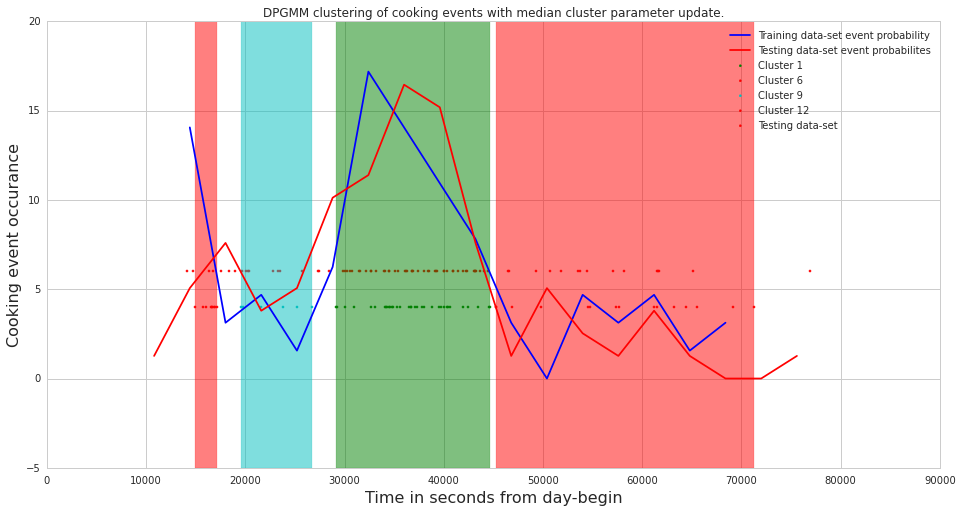

In [82]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
## describe with data && data2
## data -> clusters+2
## data2 -> clusters+3
## play with alpha
CT = data2
#dpgmm = mixture.DPGMM(n_components=len(set(clusters))+2, covariance_type='tied', params='wc', alpha=1,n_iter=1000)
dpgmm = mixture.DPGMM(n_components=20, covariance_type='spherical', params='wm', alpha=100.0,n_iter=1000)

dpgmm.fit(CT)


fig, ax = plt.subplots()

for i, (clf, title) in enumerate([(dpgmm, 'DPGMM clustering of cooking events with median cluster parameter update.')]):
    #splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(CT)
    for i, (mean, covar, color) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
        
        v, w = linalg.eigh(covar)
        #print w
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color, label = "Cluster " + str(i))
        print min(CT[Y_ == i, 0]), max(CT[Y_ == i, 0])
        plt.axvspan(min(CT[Y_ == i, 0]),max(CT[Y_ == i, 0]), color=color, alpha=0.5)  
        
        
    #ax = sns.kdeplot(np.array(learnedCookingTimesDF.sec.values))
    ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probability', color='b')
    ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probabilites', color='r')
    ax.scatter(*np.transpose(newData), color='red',label='Testing data-set', marker=".")
        
    plt.title(title)
    plt.xlabel("Time in seconds from day-begin", fontsize=16)
    plt.ylabel("Cooking event occurance", fontsize=16)
plt.legend(loc='upper right');

[[ -5.        ]
 [ -4.98498498]
 [ -4.96996997]
 [ -4.95495495]
 [ -4.93993994]
 [ -4.92492492]
 [ -4.90990991]
 [ -4.89489489]
 [ -4.87987988]
 [ -4.86486486]
 [ -4.84984985]
 [ -4.83483483]
 [ -4.81981982]
 [ -4.8048048 ]
 [ -4.78978979]
 [ -4.77477477]
 [ -4.75975976]
 [ -4.74474474]
 [ -4.72972973]
 [ -4.71471471]
 [ -4.6996997 ]
 [ -4.68468468]
 [ -4.66966967]
 [ -4.65465465]
 [ -4.63963964]
 [ -4.62462462]
 [ -4.60960961]
 [ -4.59459459]
 [ -4.57957958]
 [ -4.56456456]
 [ -4.54954955]
 [ -4.53453453]
 [ -4.51951952]
 [ -4.5045045 ]
 [ -4.48948949]
 [ -4.47447447]
 [ -4.45945946]
 [ -4.44444444]
 [ -4.42942943]
 [ -4.41441441]
 [ -4.3993994 ]
 [ -4.38438438]
 [ -4.36936937]
 [ -4.35435435]
 [ -4.33933934]
 [ -4.32432432]
 [ -4.30930931]
 [ -4.29429429]
 [ -4.27927928]
 [ -4.26426426]
 [ -4.24924925]
 [ -4.23423423]
 [ -4.21921922]
 [ -4.2042042 ]
 [ -4.18918919]
 [ -4.17417417]
 [ -4.15915916]
 [ -4.14414414]
 [ -4.12912913]
 [ -4.11411411]
 [ -4.0990991 ]
 [ -4.08408408]
 [ -4.06

'\nfor kernel in [\'gaussian\', \'tophat\', \'epanechnikov\']:\n    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)\n    log_dens = kde.score_samples(X_plot)\n    ax.plot(X_plot[:, 0], np.exp(log_dens), \'-\',\n            label="kernel = \'{0}\'".format(kernel))\n\nax.text(6, 0.38, "N={0} points".format(N))\n\nax.legend(loc=\'upper left\')\nax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), \'+k\')\n\nax.set_xlim(-4, 9)\nax.set_ylim(-0.02, 0.4)\nplt.show()\n'

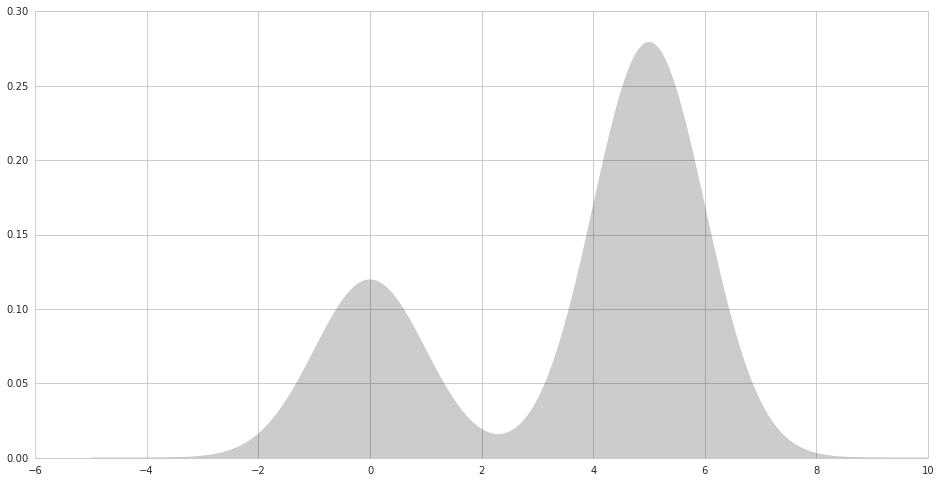

In [83]:
from scipy.stats import norm
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, 0.3 * N),
                    np.random.normal(5, 1, 0.7 * N)))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
print X_plot

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

'''
for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()
'''

46867 71286
29133 45245
14926 26684


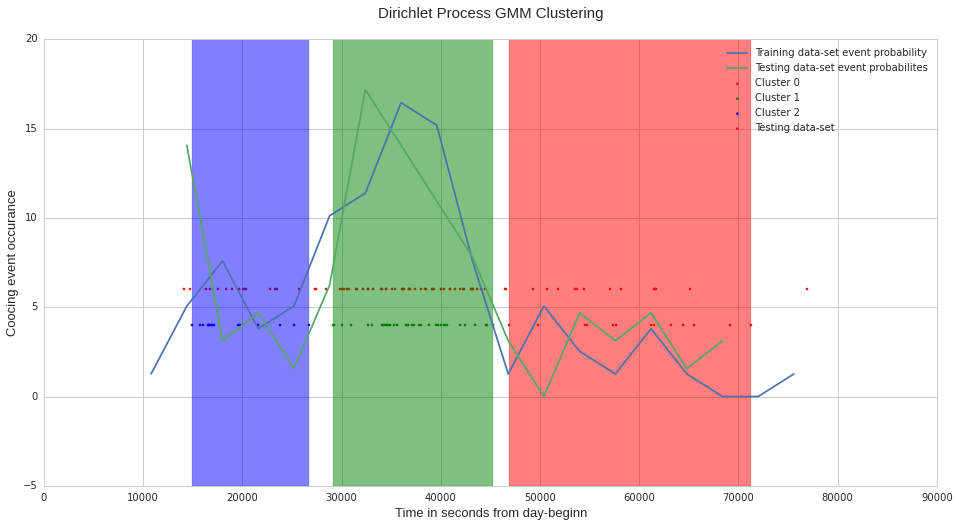

In [84]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
## describe with data && data2
## data -> clusters+2
## data2 -> clusters+3
## play with alpha
CT = data2
#dpgmm = mixture.DPGMM(n_components=len(set(clusters))+2, covariance_type='tied', params='wc', alpha=1,n_iter=1000)
dpgmm = mixture.DPGMM(n_components=3, covariance_type='full', params='m', alpha=1,n_iter=100)
dpgmm.fit(CT)

fig, ax = plt.subplots()
for i, (clf, title) in enumerate([(dpgmm, 'Dirichlet Process GMM Clustering\n')]):
    #splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(CT)
    for i, (mean, covar, color) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
        
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color, label = "Cluster " + str(i))
        print min(CT[Y_ == i, 0]), max(CT[Y_ == i, 0])
        plt.axvspan(min(CT[Y_ == i, 0]),max(CT[Y_ == i, 0]), color=color, alpha=0.5)  
        
        
        

        

    ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probability')
    ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probabilites')
    ax.scatter(*np.transpose(newData), color='red',label='Testing data-set', marker=".")
        
    plt.title(title, fontsize=15)
    plt.xlabel("Time in seconds from day-beginn", fontsize=13)
    plt.ylabel("Coocing event occurance", fontsize=13)
plt.legend(loc='upper right');

In [85]:
## append clusterNr to dataframe
Y = dpgmm.predict(CT)

for i, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
        #print(C[Y_ == i, 0], C[Y_ == i, 1])
        meanx = mean[0]
        #seconds=(meanx/1000)%60
        #minutes=(meanx/(1000*60))%60
        #hours=(meanx/(3600))
        if len(CT[Y==i,0]) > 0:
            print "Cluster", i, " Elements: ",len(CT[Y==i,0]), " Mean ", mean[0],time.strftime('%H:%M:%S', time.gmtime(mean[0]))#, " Time:", hours,":",minutes,":",seconds
            for z in enumerate(CT[Y==i,0]):
                #print "---", z[1]
                # append cluster# to row
                learnedCookingTimesDF.loc[learnedCookingTimesDF.sec == z[1], 'dpgmmcluster'] = i
                    #print "Size:", pd.DataFrame(bedroomactivity.loc[bedroomactivity.msseconddelta == z[1]]).size

Cluster 0  Elements:  13  Mean  55512.1316721 15:25:12
Cluster 1  Elements:  36  Mean  36337.9999069 10:05:37
Cluster 2  Elements:  15  Mean  17753.8840616 04:55:53


In [86]:
# just for comparison -> don't execute
'''
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
## describe with data && data2
## data -> clusters+2
## data2 -> clusters+3
## play with alpha
CT = data
dpgmm = mixture.DPGMM(n_components=len(set(clusters))+2, covariance_type='full', params='wc', alpha=1,n_iter=1000)
dpgmm.fit(CT)

for i, (clf, title) in enumerate([(dpgmm, 'DPGMM Cooking Time with Astimated Nr of Clusters')]):
    #splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(CT)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color)

        

    plt.title(title)
'''

"\ncolor_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])\n## describe with data && data2\n## data -> clusters+2\n## data2 -> clusters+3\n## play with alpha\nCT = data\ndpgmm = mixture.DPGMM(n_components=len(set(clusters))+2, covariance_type='full', params='wc', alpha=1,n_iter=1000)\ndpgmm.fit(CT)\n\nfor i, (clf, title) in enumerate([(dpgmm, 'DPGMM Cooking Time with Astimated Nr of Clusters')]):\n    #splot = plt.subplot(2, 1, 1 + i)\n    Y_ = clf.predict(CT)\n    for i, (mean, covar, color) in enumerate(zip(\n            clf.means_, clf._get_covars(), color_iter)):\n        # as the DP will not use every component it has access to\n        # unless it needs it, we shouldn't plot the redundant\n        # components.\n        if not np.any(Y_ == i):\n            continue\n        plt.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color)\n\n        \n\n    plt.title(title)\n"

In [87]:
#learnedCookingTimesToCluster = learnedCookingTimesToCluster.drop('dpgmmcluster', 1)

In [88]:
learnedCookingTimesToCluster.dtypes

CMeanTime    datetime64[ns]
number                int64
sec                   int64
tocluster              bool
hcluster            float64
dtype: object

In [89]:
probabilityMap = defaultdict(int)
## iterade over dpgmm clusters
for dpgmmcluster, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
    if len(CT[Y==dpgmmcluster,0]) > 0:
        #print "cluster:", dpgmmcluster, " Elements: ",len(CT[Y==dpgmmcluster,0])
        clusterStartTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.min().time()
        clusterEndTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.max().time()
        duration = datetime.combine(date.today(), clusterEndTime) - datetime.combine(date.today(), clusterStartTime)
        weight = dpgmm.weights_[dpgmmcluster]
        print "cluster:", dpgmmcluster, " Elements: ",len(CT[Y==dpgmmcluster,0]),",start:", clusterStartTime, ", end:", clusterEndTime, "duration:", duration, "percentage:", len(learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster])*100/len(learnedCookingTimesDF),",weight:"+ str(weight)
        probabilityMap[dpgmmcluster] = len(learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster])*100/len(learnedCookingTimesDF)

cluster: 0  Elements:  13 ,start: 13:01:07 , end: 19:48:06 duration: 6:46:59 percentage: 20 ,weight:0.131782968192
cluster: 1  Elements:  36 ,start: 08:05:33 , end: 12:34:05 duration: 4:28:32 percentage: 56 ,weight:0.301218152255
cluster: 2  Elements:  15 ,start: 04:08:46 , end: 07:24:44 duration: 3:15:58 percentage: 23 ,weight:0.566998879554


In [90]:
clusterHitCouter = defaultdict(int)

def check_for_hit(row):
    eventTime = row["CMeanTime"].time()
    for dpgmmcluster, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
        if len(CT[Y==dpgmmcluster,0]) > 0:
            #print "cluster:", dpgmmcluster, " Elements: ",len(CT[Y==i,0])
            clusterStartTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.min().time()
            clusterEndTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.max().time()
            #print "cluster:", dpgmmcluster, ",start:", clusterStartTime, ", end:", clusterEndTime
            if clusterStartTime <= eventTime <= clusterEndTime:
                print "hit", "s", clusterStartTime, "e", clusterEndTime, "event", eventTime
                clusterHitCouter[dpgmmcluster] += 1
                return 1
            else:
                print "miss", "s", clusterStartTime, "e", clusterEndTime, "event", eventTime 
    
    return 0

newCookingTimesDF['dpgmmhit'] = newCookingTimesDF.apply(lambda row: check_for_hit(row), axis=1)

## method 2 Hit/Miss Rate ##
method2HitEventsCounter = newCookingTimesDF[newCookingTimesDF.dpgmmhit==1].sum()["dpgmmhit"]
method2MissEventsCounter = len(newCookingTimesDF[newCookingTimesDF.dpgmmhit==0]["dpgmmhit"].values)

print "hits:", method2HitEventsCounter
print "miss:", method2MissEventsCounter
print "hitrate by event number:", (100*method2HitEventsCounter)/(method2HitEventsCounter+method2MissEventsCounter), "%"

hit s 13:01:07 e 19:48:06 event 17:06:14
miss s 13:01:07 e 19:48:06 event 09:49:57
hit s 08:05:33 e 12:34:05 event 09:49:57
miss s 13:01:07 e 19:48:06 event 10:41:54
hit s 08:05:33 e 12:34:05 event 10:41:54
hit s 13:01:07 e 19:48:06 event 17:09:03
miss s 13:01:07 e 19:48:06 event 04:52:09
miss s 08:05:33 e 12:34:05 event 04:52:09
hit s 04:08:46 e 07:24:44 event 04:52:09
miss s 13:01:07 e 19:48:06 event 09:04:39
hit s 08:05:33 e 12:34:05 event 09:04:39
miss s 13:01:07 e 19:48:06 event 11:44:15
hit s 08:05:33 e 12:34:05 event 11:44:15
miss s 13:01:07 e 19:48:06 event 11:06:49
hit s 08:05:33 e 12:34:05 event 11:06:49
miss s 13:01:07 e 19:48:06 event 06:27:21
miss s 08:05:33 e 12:34:05 event 06:27:21
hit s 04:08:46 e 07:24:44 event 06:27:21
miss s 13:01:07 e 19:48:06 event 10:22:44
hit s 08:05:33 e 12:34:05 event 10:22:44
miss s 13:01:07 e 19:48:06 event 10:34:13
hit s 08:05:33 e 12:34:05 event 10:34:13
miss s 13:01:07 e 19:48:06 event 08:19:57
hit s 08:05:33 e 12:34:05 event 08:19:57
miss

In [91]:
# cluster hit statistics
for k in clusterHitCouter:
    print k, clusterHitCouter[k], clusterHitCouter[k]*100/(method2HitEventsCounter+method2MissEventsCounter)

0 12 15
1 46 58
2 13 16


46867 71286
<type 'numpy.float64'>
29133 45245
<type 'numpy.float64'>
14926 26684
<type 'numpy.float64'>


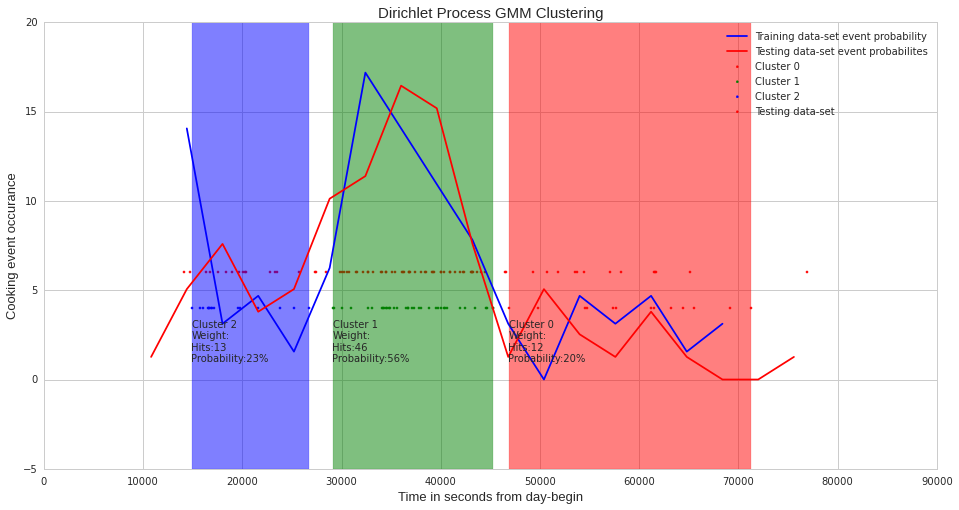

In [92]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
fig, ax = plt.subplots()
for i, (clf, title) in enumerate([(dpgmm, 'Dirichlet Process GMM Clustering')]):
    #splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(CT)
    for i, (mean, covar, color1) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
        
        #print len(clf.weights_)
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(CT[Y_ == i, 0], CT[Y_ == i, 1], 5, color=color1, label = "Cluster " + str(i))
        print min(CT[Y_ == i, 0]), max(CT[Y_ == i, 0])
        plt.axvspan(min(CT[Y_ == i, 0]),max(CT[Y_ == i, 0]), color=color1, alpha=0.5)  
        plt.annotate("Cluster "+str(i)+"\nWeight:"+str("")+"\nHits:"+str(clusterHitCouter[i])+"\nProbability:"+str(probabilityMap[i])+"%", (min(CT[Y_ == i, 0]),min(CT[Y_ == i, 1]-3)))
        print type(clf.weights_[i])
        

        

    ax.plot(*np.transpose(lmtg60Df[["sec","eventprobability"]].values), label='Training data-set event probability', color='b')
    ax.plot(*np.transpose(cmtg60Df[["sec","eventprobability"]].values), label='Testing data-set event probabilites', color='r')
    ax.scatter(*np.transpose(newData), color='red',label='Testing data-set', marker=".")
        
    plt.title(title, fontsize=15)
    plt.xlabel("Time in seconds from day-begin", fontsize=13)
    plt.ylabel("Cooking event occurance", fontsize=13)
plt.legend(loc='upper right');

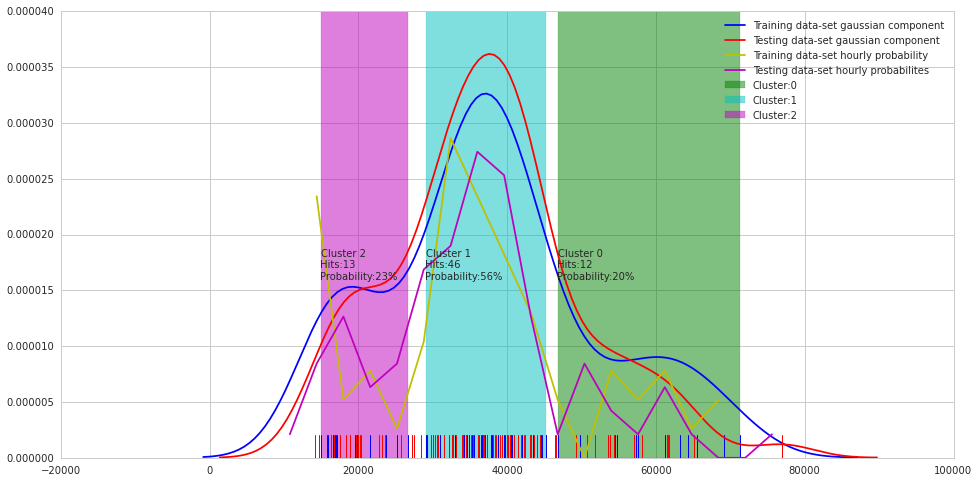

In [115]:
#print lmtg60Df[["sec","eventprobability"]].values
# do normalisation on hourly probability values
lmtg60Df["eventprobabilitynormalised"] = lmtg60Df["eventprobability"]/600000
cmtg60Df["eventprobabilitynormalised"] = cmtg60Df["eventprobability"]/600000

from scipy.stats.kde import gaussian_kde
# create fake data
trainingData = learnedCookingTimesDF.sec.values
testingData = newCookingTimesDF.sec.values
fig, ax = plt.subplots()
# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde( trainingData )
kde2 = gaussian_kde(testingData)
# these are the values over wich your kernel will be evaluated
dist_space = np.linspace( min(trainingData), max(trainingData), 1000 )
dist_space2 = np.linspace(min(testingData),max(testingData),1000)
# plot the results

# plot density curves
#plt.plot( dist_space, kde(dist_space), label="TrainingData", color='b')
#plt.plot(dist_space2, kde2(dist_space2), label = "TestingData", color='r')

sns.distplot(trainingData, kde=True, hist=False,rug=True, ax=ax, color='b',label="Training data-set gaussian component",norm_hist=True,);
sns.distplot(testingData, kde=True, hist=False,rug=True, ax=ax, color='r',label="Testing data-set gaussian component",norm_hist=True,);

ax.plot(*np.transpose(lmtg60Df[["sec","eventprobabilitynormalised"]].values), label='Training data-set hourly probability', color='y') 
ax.plot(*np.transpose(cmtg60Df[["sec","eventprobabilitynormalised"]].values), label='Testing data-set hourly probabilites', color='m')


color_iter = itertools.cycle([ 'g', 'c', 'm','y'])
for i, (clf, title) in enumerate([(dpgmm, 'DPGMM clustering \n')]): 
    #splot = plt.subplot(2, 1, 1 + i)
    #Y_ = clf.predict(CT)
    for i, (mean, covar, color) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
        
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.axvspan(min(CT[Y_ == i, 0]),max(CT[Y_ == i, 0]), color=color, alpha=0.5, label="Cluster:"+str(i)) 
        plt.annotate("Cluster "+str(i)+"\nHits:"+str(clusterHitCouter[i])+"\nProbability:"+str(probabilityMap[i])+"%", (min(CT[Y_ == i, 0]),0.000016))  
        
plt.legend(loc='upper right', shadow=True)



In [94]:
## method 2 Hit/Miss Rate ##
method2HitEventsCounter = newCookingTimesDF[newCookingTimesDF.dpgmmhit==1].sum()["dpgmmhit"]
method2MissEventsCounter = len(newCookingTimesDF[newCookingTimesDF.dpgmmhit==0]["dpgmmhit"].values)

print "hits:", method2HitEventsCounter
print "miss:", method2MissEventsCounter
print "hitrate by event number:", (100*method2HitEventsCounter)/(method2HitEventsCounter+method2MissEventsCounter), "%" 

hits: 71
miss: 8
hitrate by event number: 89 %


In [95]:
newCookingTimesDF[newCookingTimesDF.dpgmmhit==0]

,CMeanTime,number,sec,hclusteringhit1,hit,dpgmmhit
21,2016-06-07 04:04:54,6,14694,0,0,0
30,2016-06-07 12:56:42,6,46602,1,0,0
36,2016-06-07 12:54:39,6,46479,1,0,0
37,2016-06-07 07:53:34,6,28414,0,0,0
56,2016-06-07 07:34:43,6,27283,0,0,0
69,2016-06-07 03:55:52,6,14152,0,0,0
70,2016-06-07 07:37:47,6,27467,0,0,0
74,2016-06-07 21:22:26,6,76946,0,0,0


In [49]:
clusterStartTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.min().hour

AttributeError: 'float' object has no attribute 'hour'

In [50]:
## checking by hours
def check_for_hit(row):
    eventTime = row["CMeanTime"].time()
    for dpgmmcluster, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
        if len(CT[Y==dpgmmcluster,0]) > 0:
            #print "cluster:", dpgmmcluster, " Elements: ",len(CT[Y==i,0])
            clusterStartTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.min().time().hour
            clusterEndTime = learnedCookingTimesDF[learnedCookingTimesDF.dpgmmcluster==dpgmmcluster].CMeanTime.max().time().hour
            #print "cluster:", dpgmmcluster, ",start:", clusterStartTime, ", end:", clusterEndTime
            if clusterStartTime <= eventTime.hour <= clusterEndTime:
                print "hit", "s", clusterStartTime, "e", clusterEndTime, "event", eventTime
                return 1
            else:
                print "miss", "s", clusterStartTime, "e", clusterEndTime, "event", eventTime 
    
    return 0

newCookingTimesDF['dpgmmhitRoundH'] = newCookingTimesDF.apply(lambda row: check_for_hit(row), axis=1)

miss s 5 e 7 event 17:06:14
hit s 13 e 19 event 17:06:14
miss s 5 e 7 event 09:49:57
miss s 13 e 19 event 09:49:57
miss s 4 e 4 event 09:49:57
hit s 8 e 12 event 09:49:57
miss s 5 e 7 event 10:41:54
miss s 13 e 19 event 10:41:54
miss s 4 e 4 event 10:41:54
hit s 8 e 12 event 10:41:54
miss s 5 e 7 event 17:09:03
hit s 13 e 19 event 17:09:03
miss s 5 e 7 event 04:52:09
miss s 13 e 19 event 04:52:09
hit s 4 e 4 event 04:52:09
miss s 5 e 7 event 09:04:39
miss s 13 e 19 event 09:04:39
miss s 4 e 4 event 09:04:39
hit s 8 e 12 event 09:04:39
miss s 5 e 7 event 11:44:15
miss s 13 e 19 event 11:44:15
miss s 4 e 4 event 11:44:15
hit s 8 e 12 event 11:44:15
miss s 5 e 7 event 11:06:49
miss s 13 e 19 event 11:06:49
miss s 4 e 4 event 11:06:49
hit s 8 e 12 event 11:06:49
hit s 5 e 7 event 06:27:21
miss s 5 e 7 event 10:22:44
miss s 13 e 19 event 10:22:44
miss s 4 e 4 event 10:22:44
hit s 8 e 12 event 10:22:44
miss s 5 e 7 event 10:34:13
miss s 13 e 19 event 10:34:13
miss s 4 e 4 event 10:34:13
hit 

In [51]:
## method 2 Hit/Miss Rate ##
method2HitEventsCounter = newCookingTimesDF[newCookingTimesDF.dpgmmhitRoundH==1].sum()["dpgmmhitRoundH"]
method2MissEventsCounter = len(newCookingTimesDF[newCookingTimesDF.dpgmmhitRoundH==0]["dpgmmhitRoundH"].values)

print "hits:", method2HitEventsCounter
print "miss:", method2MissEventsCounter
print "hitrate by event number:", (100*method2HitEventsCounter)/(method2HitEventsCounter+method2MissEventsCounter), "%" 

hits: 77
miss: 2
hitrate by event number: 97 %
